In [1]:
!cat /proc/meminfo

MemTotal:       32949048 kB
MemFree:        31195996 kB
MemAvailable:   31990928 kB
Buffers:          129316 kB
Cached:           989228 kB
SwapCached:            0 kB
Active:           956968 kB
Inactive:         607036 kB
Active(anon):     445736 kB
Inactive(anon):       56 kB
Active(file):     511232 kB
Inactive(file):   606980 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:             67708 kB
Writeback:            72 kB
AnonPages:        445856 kB
Mapped:           125220 kB
Shmem:                68 kB
Slab:             102796 kB
SReclaimable:      80264 kB
SUnreclaim:        22532 kB
KernelStack:        3792 kB
PageTables:         5452 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:    16474524 kB
Committed_AS:    1524924 kB
VmallocTotal:   34359738367 kB
VmallocUsed:           0 kB
VmallocChunk:          0 kB
AnonHugePages:         0 kB
ShmemHugePages:  

In [2]:
!pip install xgboost msgpack

    100% |████████████████████████████████| 15.8MB 3.5MB/s eta 0:00:01
    100% |████████████████████████████████| 317kB 43.3MB/s ta 0:00:01
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import io
import time
import json
import gc
import pickle

from sklearn import preprocessing as prp
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import (accuracy_score, r2_score, confusion_matrix,
f1_score, recall_score, precision_score)

import os
import boto3
import re

import xgboost as xgb
#import lightgbm as lgb 

# ruta de trabajo en s3
bucket = 'boi-banregio'
target = 'BMI'
feat_part_number = 40

pd.options.display.max_rows = 4000

# s3 resource
s3_bucket_resource = boto3.resource('s3').Bucket(bucket)

In [216]:
#!ls -la / & strings /lib64/libc.so.6 | grep ^GLIBC_
# !git clone --recursive https://github.com/Microsoft/LightGBM
#!ls -la LightGBM/
#!mkdir LightGBM/build
!pip freeze


alabaster==0.7.10
anaconda-client==1.6.14
anaconda-project==0.8.2
asn1crypto==0.24.0
astroid==1.6.3
astropy==3.0.2
attrs==18.1.0
awscli==1.16.9
Babel==2.5.3
backcall==0.1.0
backports.shutil-get-terminal-size==1.0.0
beautifulsoup4==4.6.0
bitarray==0.8.1
bkcharts==0.2
blaze==0.11.3
bleach==2.1.3
bokeh==0.12.16
boto==2.48.0
boto3==1.8.9
botocore==1.11.9
Bottleneck==1.2.1
certifi==2018.8.24
cffi==1.11.5
chardet==3.0.4
click==6.7
cloudpickle==0.5.3
clyent==1.2.2
colorama==0.3.9
contextlib2==0.5.5
cryptography==2.2.2
cycler==0.10.0
Cython==0.28.2
cytoolz==0.9.0.1
dask==0.17.5
datashape==0.5.4
decorator==4.3.0
distributed==1.21.8
docutils==0.14
entrypoints==0.2.3
environment-kernels==1.1.1
et-xmlfile==1.0.1
fastcache==1.0.2
filelock==3.0.4
Flask==1.0.2
Flask-Cors==3.0.4
gevent==1.3.0
glob2==0.6
gmpy2==2.0.8
greenlet==0.4.13
h5py==2.7.1
heapdict==1.0.0
html5lib==1.0.1
idna==2.6
imageio==2.3.0
imagesize==1.0.0
ipykernel==4.8.2
ipython==6.4.0
ipython-genutils==0.2.0
ipywidgets==7.2.1
isort==4.3.

In [4]:
from itertools import chain, zip_longest

def predict(probs, threshold):
    preds = []
    for prob in probs:
        if prob > threshold:
            preds.append(1)
        else:
            preds.append(0)
    return np.array(preds)

# fval for hyperparameters
def val_func(pred_probs, dmat):
    thrs = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
    ret = []
    for thr in thrs:
        preds = predict(pred_probs, thr)
        score = f1_score(preds, dmat.get_float_info('label'))
        ret.append(('f1_score_thr{}'.format(thr), score))
    return ret

def val_func_thr(bst, dtest, test_y):
    f1_sc = 0
    max_step = 0
    thr_sample = (dtest, test_y)
    _score_preds = bst.predict(thr_sample[0])
    for thr_step in np.linspace(0, 1, 101):
        _preds = predict(_score_preds, thr_step)
        f1_sc_step = f1_score(thr_sample[1], _preds)        
        if f1_sc_step >= f1_sc:
            f1_sc = f1_sc_step
            max_step = thr_step
    # threshold = max_step
    return max_step, f1_sc  # threshold, f1score max value

def pretty_table(matrix):
    matrix_aux = chain.from_iterable(
        zip_longest(
            *(x.splitlines() for x in y),
            fillvalue='')
        for y in [[str(e) for e in row] for row in matrix])

    s = [[str(e) for e in row] for row in matrix_aux]
    lens = [max(map(len, col)) for col in zip(*s)]
    fmt = '\t'.join('{{:{}}}'.format(x) for x in lens)
    table = [fmt.format(*row) for row in s]
    print('\n'.join(table))
    
def get_xgb_feat_importances(clf):
    if isinstance(clf, xgb.XGBModel):
        # clf has been created by calling
        # xgb.XGBClassifier.fit() or xgb.XGBRegressor().fit()
        fscore = clf.booster().get_fscore()
    else:
        # clf has been created by calling xgb.train.
        # Thus, clf is an instance of xgb.Booster.
        fscore = clf.get_fscore()

    feat_importances = []
    for ft, score in fscore.items():
        feat_importances.append({'Feature': ft, 'Importance': score})
    feat_importances = pd.DataFrame(feat_importances)
    feat_importances = feat_importances.sort_values(
        by='Importance', ascending=False).reset_index(drop=True)
    # Divide the importances by the sum of all importances
    # to get relative importances. By using relative importances
    # the sum of all importances will equal to 1, i.e.,
    # np.sum(feat_importances['importance']) == 1
    feat_importances['Importance'] /= feat_importances['Importance'].sum()
    # Print the most important features and their importances
    print(feat_importances.head())
    return feat_importances

### Cargamos información

In [5]:
# Aquí colocamos la ruta de nuestro directorio, el nombre de nuestro archivo y si tiene o no cabecera
prefix = 'datalake/data/InteligenciaRiesgos/M&M/MCV/DATASETS_3/JAT_MCV_VAR_VARIABLES_SELECCION/PARTITION'

In [6]:
target_file_name = "TARGETS.csv"
target_file_key = "{}/{}".format(prefix, target_file_name)
target_obj = s3_bucket_resource.Object(target_file_key).get()
target_data = pd.read_csv(io.BytesIO(target_obj['Body'].read())).loc[:,[target]]

In [7]:
# model_features_file_name = "MODEL_DATASET/MODEL_FEATURES.csv"
model_features_file_name = "MODEL_DATASET/MODEL_FEATURES+EXTRAS.csv"
model_features_file_key = "{}/{}".format(prefix, model_features_file_name)
model_features_obj = s3_bucket_resource.Object(model_features_file_key).get()
model_features_data = pd.read_csv(io.BytesIO(model_features_obj['Body'].read()))

In [8]:
date_features_file_name = "EXTRA_FEATURES/MCV_TRIMESTRE.csv"
date_features_file_key = "{}/{}".format(prefix, date_features_file_name)
date_features_obj = s3_bucket_resource.Object(date_features_file_key).get()
date_features_data = pd.read_csv(io.BytesIO(date_features_obj['Body'].read()))

In [9]:
rfc_key_features_file_name = "EXTRA_FEATURES/MCV_VAR_RFC_FECHA_LLAVE.csv"
rfc_key_features_file_key = "{}/{}".format(prefix, rfc_key_features_file_name)
rfc_key_features_obj = s3_bucket_resource.Object(rfc_key_features_file_key).get()
rfc_key_features_data = pd.read_csv(io.BytesIO(rfc_key_features_obj['Body'].read()))

In [10]:
monto_linea_features_file_name = "EXTRA_FEATURES/JAT_MCV_VAR_VARIABLES_SELECCION_MONTO_LINEA.csv"
monto_linea_features_file_key = "{}/{}".format(prefix, monto_linea_features_file_name)
monto_linea_features_obj = s3_bucket_resource.Object(monto_linea_features_file_key).get()
monto_linea_features_data = pd.read_csv(io.BytesIO(monto_linea_features_obj['Body'].read()))

### Selección de modelo con instancias independientes


In [12]:
def sampler(data, periods, sample, period_samples, sample_exclude, month_size=500, seed=0):
    # period_samples = []
    if periods:
        period = (data['FECHA'] == periods.pop()) & (~sample_exclude)
        
        local_universe = data[period].drop_duplicates('RFC')
        
        print(local_universe.shape)
        period_samples.append(local_universe.sample(month_size, random_state=seed))
        
        #period_samples.append(pd.Series(data.index.isin(period_sample.index)))        
        
        sample = pd.Series(data.index.isin(period_samples[-1].index)) | sample
        sample_exclude = data['RFC'].isin(period_samples[-1]['RFC']) | sample_exclude
        return sampler(data, periods, sample, period_samples, sample_exclude, month_size, seed)
    else:
        return sample, period_samples, sample_exclude


periods = [201702, 201703, 201704, 201705]

sample = pd.Series([False]*rfc_key_features_data.shape[0])
period_samples = []
sample_exclude = sample
sample, period_samples, sample_exclude = sampler(rfc_key_features_data, periods, sample, period_samples, sample_exclude, month_size=2350)
display(sample.sum())
display(sample_exclude.sum())

(9088, 3)
(6736, 3)
(4551, 3)
(2401, 3)


9400

366790

In [13]:
#sample_m1 = (rfc_key_features_data[sample] == 201708)
#rfc_key_features_data[sample_m1]

#display(period_samples[0])

m0 = (rfc_key_features_data['FECHA']==201701) & (
    rfc_key_features_data['LLAVE_UNIVERSAL_20'].isin(
        period_samples[0]['LLAVE_UNIVERSAL_20']))

m1 = (rfc_key_features_data['FECHA']==201612) & (
    rfc_key_features_data['LLAVE_UNIVERSAL_20'].isin(
        period_samples[1]['LLAVE_UNIVERSAL_20']))

m2 = (rfc_key_features_data['FECHA']==201611) & (
    rfc_key_features_data['LLAVE_UNIVERSAL_20'].isin(
        period_samples[2]['LLAVE_UNIVERSAL_20']))

m3 = (rfc_key_features_data['FECHA']==201610) & (
    rfc_key_features_data['LLAVE_UNIVERSAL_20'].isin(
        period_samples[3]['LLAVE_UNIVERSAL_20']))

m4 = (rfc_key_features_data['FECHA']==201609) & (
    rfc_key_features_data['LLAVE_UNIVERSAL_20'].isin(
        period_samples[0]['LLAVE_UNIVERSAL_20']))

m5 = (rfc_key_features_data['FECHA']==201608) & (
    rfc_key_features_data['LLAVE_UNIVERSAL_20'].isin(
        period_samples[1]['LLAVE_UNIVERSAL_20']))

m6 = (rfc_key_features_data['FECHA']==201607) & (
    rfc_key_features_data['LLAVE_UNIVERSAL_20'].isin(
        period_samples[2]['LLAVE_UNIVERSAL_20']))

m7 = (rfc_key_features_data['FECHA']==201606) & (
    rfc_key_features_data['LLAVE_UNIVERSAL_20'].isin(
        period_samples[3]['LLAVE_UNIVERSAL_20']))

sample_ext = m0 | m1 | m2 | m3 | m4 | m5 | m6 | m7
display(m0.sum())
display(m1.sum())
display(m2.sum())
display(m3.sum())
display(m4.sum())
display(m5.sum())
display(m6.sum())
display(m7.sum())
display(sample_ext.sum())
sample_final = sample | sample_ext











1981

1972

736

1739

1738

1771

1698

1638

13273

In [14]:
sample_final.sum()

22673

In [196]:
periods2 = [201503, 201504, 201505, 
            201506, 201507, 201508, 201509, 201510, 
            201511, 201512, 201601, 201602, 201603]
sample2 = pd.Series([False]*rfc_key_features_data.shape[0])
sample_exclude2 = sample2
sample2, sample_exclude2 = sampler(rfc_key_features_data, periods2, sample2, sample_exclude2, month_size=600)
display(sample2.sum())
display(sample_exclude2.sum())

(7890, 3)
(7151, 3)
(6526, 3)
(5862, 3)
(5163, 3)
(4630, 3)
(4043, 3)
(3404, 3)
(2911, 3)
(2368, 3)
(1817, 3)
(1308, 3)
(799, 3)


7800

325071

In [185]:
dates = [201501, 201502, 201503, 201504, 201505, 
         201506, 201507, 201508, 201509, 201510, 
         201511, 201512, 201601, 201602, 201603, 
         201604, 201605, 201606, 201607, 201608]

periods = [201609, 201610, 201611, 201612, 201701, 
           201702, 201703, 201704, 201705, 201706, 
           201707, 201708, 201709, 201710, 201711]

periods2 = [201503, 201504, 201505, 
            201506, 201507, 201508, 201509, 201510, 
            201511, 201512, 201601, 201602, 201603]



for date in dates:
    period = (rfc_key_features_data['FECHA'] == date)# & ~sample_exclude
    local_universe = rfc_key_features_data[period].drop_duplicates('RFC')
    display(local_universe.shape)

(6460, 3)

(6473, 3)

(6627, 3)

(6691, 3)

(6766, 3)

(6928, 3)

(7010, 3)

(6993, 3)

(7219, 3)

(7298, 3)

(7301, 3)

(7501, 3)

(7653, 3)

(7715, 3)

(7890, 3)

(7989, 3)

(8038, 3)

(8308, 3)

(8469, 3)

(8551, 3)

41552

### Variable "BUENO"

In [245]:
BUENO = target_data['BMI'] == 0
BUENO.sum()

408559

In [271]:
target_bueno = target_data[BUENO]
target_bueno.head(300)

np.random.seed(0)
rand_BUENO_split = np.random.rand(len(target_bueno))
include_list = rand_BUENO_split < 0.8
# drop_list = rand_BUENO_split >= 0.5

target_bueno_includes = target_bueno[include_list]
target_bueno_includes.head()

REDUCCION_BUENO = pd.Series(target_data.index.isin(target_bueno_includes.index)) | ~BUENO
REDUCCION_BUENO.sum()

343786

### Variable "MONTO_LINEA"

In [15]:
monto_linea_features_data.apply(pd.to_numeric)
MONTO_LINEA = (monto_linea_features_data['MONTO_LINEA'] < 8000000) & (monto_linea_features_data['MONTO_LINEA'] > 1)
display(MONTO_LINEA.sum())

398637

### Variables "TRIMESTRE", "PERIODO"

In [132]:
TRIMESTRE = (date_features_data['TRIMESTRE'] == 3) | (date_features_data['TRIMESTRE'] == 4)
display(TRIMESTRE.sum())

207622

In [52]:
# PERIODO = ((date_features_data['FECHA'] == 201501) 
# | (date_features_data['FECHA'] == 201508) 
# | (date_features_data['FECHA'] == 201603)
# | (date_features_data['FECHA'] == 201610)
# | (date_features_data['FECHA'] == 201705))

PERIODO_TRAIN = ((date_features_data['FECHA'] == 201701)
                 |(date_features_data['FECHA'] == 201609) 
                 |(date_features_data['FECHA'] == 201606)
                 |(date_features_data['FECHA'] == 201602)
                 |(date_features_data['FECHA'] == 201511)
                 |(date_features_data['FECHA'] == 201507)
                 |(date_features_data['FECHA'] == 201504)
                 |(date_features_data['FECHA'] == 201501))
PERIODO_TEST = date_features_data['FECHA'] == 201707

display(PERIODO_TRAIN.sum())
display(PERIODO_TEST.sum())

94908

13634

In [122]:
PERIODO = date_features_data['FECHA'] == 201711
display(PERIODO.sum())

13892

In [172]:
PERIODO2 = ((date_features_data['FECHA'] == 201504) 
| (date_features_data['FECHA'] == 201511) 
| (date_features_data['FECHA'] == 201606)
| (date_features_data['FECHA'] == 201701)
| (date_features_data['FECHA'] == 201708))
display(PERIODO2.sum())

61982

### Variable "DIAS_ATRASO"

In [97]:
DATRASO = model_features_data['DIAS_ATRASO'] > 0

In [13]:
INDETERMINADOS1 = DATRASO & BUENO
display(INDETERMINADOS1.sum())
display(model_features_data[INDETERMINADOS1].head())
display(target_data[INDETERMINADOS1].head())

21783

,AVG_R_BAL_BY_CRED_LIM_12M,DEUDA_TOT,MIN_R_BAL_BY_MAX_BAL_03M,MAX_D_CRED_LIM_TO_BAL_03M,AVG_D_CRED_LIM_TO_BAL_06M,AVG_PND_MENOS_R_BAL_BY_MAX_BAL_06M,AVG_R_BAL_BY_MAX_BAL_12M,AVG_PND_MENOS_BAL_12M,BK12_MAX_CREDIT_AMT,AVG_PND_MAS_BAL_12M,...,MAX_AVG2_VP_MES_U06M_2,MIN_AVG_HI_CALCAR_CEIL_12M,AVG_PND_MAS_MAX_HI_CALCAR_L_12M,MAX_MS_CL_BRG_R_CL_ACC,AVG_PND_MAS_MAX_HI_CALCAR_CEIL_12M,SUM_PAGOREALIZADO_PERIODO,DIAS_ATRASO,DPCV_CAP,DPCV_INT,DPCV_MIN
165,0.232773,1.067227,0.190022,2.304053,2.676436,0.058188,0.227256,4.271565,1.580645,4.114161,...,-0.046345,-0.944444,-0.874797,20.0,-0.601990,-0.255973,23,38,38,38
184,0.338380,0.327731,0.213416,-0.277413,-0.279964,0.199422,-0.621106,-0.319099,-0.161290,-0.321483,...,-0.060490,-0.236111,1.901492,-13.0,4.459378,-0.255973,20,41,41,41
191,0.661387,0.428571,-0.360803,-0.287763,-0.305304,0.298017,0.312038,-0.314110,0.129032,-0.311103,...,0.092392,2.472222,2.934360,-1.0,18.716509,-0.255973,21,40,40,40
192,0.679216,0.428571,-0.360803,-0.287763,-0.304487,0.309719,0.298596,-0.312733,0.129032,-0.311609,...,0.000000,2.472222,2.934360,-1.0,18.716509,0.000000,53,8,8,8
231,0.334981,0.991597,0.249036,-0.293028,-0.299668,-1.145997,-2.112532,-0.287546,0.709677,-0.309638,...,-0.049772,2.097222,2.545581,-24.0,11.936559,-0.255973,22,39,39,39


,BMI
165,0
184,0
191,0
192,0
231,0


In [14]:
INDETERMINADOS2 = ~DATRASO & ~BUENO
display(INDETERMINADOS2.sum())
display(model_features_data[INDETERMINADOS2].head())
display(target_data[INDETERMINADOS2].head())

8139

,AVG_R_BAL_BY_CRED_LIM_12M,DEUDA_TOT,MIN_R_BAL_BY_MAX_BAL_03M,MAX_D_CRED_LIM_TO_BAL_03M,AVG_D_CRED_LIM_TO_BAL_06M,AVG_PND_MENOS_R_BAL_BY_MAX_BAL_06M,AVG_R_BAL_BY_MAX_BAL_12M,AVG_PND_MENOS_BAL_12M,BK12_MAX_CREDIT_AMT,AVG_PND_MAS_BAL_12M,...,MAX_AVG2_VP_MES_U06M_2,MIN_AVG_HI_CALCAR_CEIL_12M,AVG_PND_MAS_MAX_HI_CALCAR_L_12M,MAX_MS_CL_BRG_R_CL_ACC,AVG_PND_MAS_MAX_HI_CALCAR_CEIL_12M,SUM_PAGOREALIZADO_PERIODO,DIAS_ATRASO,DPCV_CAP,DPCV_INT,DPCV_MIN
17,0.381797,0.025210,-0.187112,0.198939,0.175669,-0.163765,0.100633,0.941063,1.838710,0.909134,...,8.612719,0.027778,1.150324,35.0,1.439060,-0.255973,0,61,61,61
18,0.419356,0.050420,-0.144246,0.198851,0.083267,-0.117075,0.142812,0.956309,1.483871,0.938580,...,8.612719,0.031746,1.659959,38.0,3.377949,22.373370,0,61,61,61
19,0.421595,0.050420,-0.144246,0.172649,-0.006546,0.066218,0.150384,0.932683,1.483871,0.964386,...,8.612719,0.031746,1.659959,38.0,3.377949,-0.255973,0,61,61,61
20,0.425842,0.050420,0.343823,-0.295746,-0.046834,0.085795,0.154574,0.906707,1.483871,0.994868,...,6.008875,0.031746,1.659959,38.0,3.377949,-0.255973,0,61,61,61
185,0.353418,0.352941,0.213416,-0.277413,-0.283433,0.310314,-0.399825,-0.319681,-0.193548,-0.320201,...,-0.055167,-0.236111,2.481172,-10.0,7.174556,-0.255973,0,61,61,61


,BMI
17,1
18,1
19,1
20,1
185,1


### **Variable "REVOLVENTE"**

In [11]:
data_revol_file_name = "DATA_PART{}.csv".format(5)
data_revol_file_key = "{}/{}".format(prefix, data_revol_file_name)
data_revol_obj = s3_bucket_resource.Object(data_revol_file_key).get()
data_revol = pd.read_csv(io.BytesIO(data_revol_obj['Body'].read()))
REVOLVENTE = data_revol['REVOLVENTE'] == 1
del data_revol
display((REVOLVENTE).sum())

### Modelo completo

In [113]:
# elegimos el modelo completo
np.random.seed(0)
rand_split = np.random.rand(len(model_features_data))
train_list = (rand_split < 0.8) & ~(DATRASO & BUENO)
test_list = rand_split >= 0.8

feature_data_train = model_features_data[train_list].drop('DIAS_ATRASO', axis=1)
feature_data_test = model_features_data[test_list].drop('DIAS_ATRASO', axis=1)

target_data_train = target_data[train_list]
target_data_test = target_data[test_list]

### Datos de entrenamiento y prueba por periodos

In [57]:
# elegimos el modelo completo
# np.random.seed(0)
# rand_split = np.random.rand(len(model_features_data))
# train_list = (rand_split < 0.8) & 
# test_list = rand_split >= 0.8

feature_data_train = model_features_data[PERIODO_TRAIN]
feature_data_test = model_features_data[PERIODO_TEST]

target_data_train = target_data[PERIODO_TRAIN]
target_data_test = target_data[PERIODO_TEST]

### Submodelos

In [16]:
# submodelo
 
# BOOL_INDEX = REVOLVENTE & ~INDETERMINADOS1 & ~INDETERMINADOS2
# BOOL_INDEX = REVOLVENTE & (INDETERMINADOS1 | INDETERMINADOS2)
# BOOL_INDEX = REVOLVENTE
# BOOL_INDEX = TRIMESTRE
# BOOL_INDEX = PERIODO2
# BOOL_INDEX = -INDETERMINADOS1
# BOOL_INDEX = sample | sample2
BOOL_INDEX = sample_final & MONTO_LINEA  # & REDUCCION_BUENO
BOOL_INDEX.sum()

21725

In [19]:
# elegimos submodelo
submodel_features_data = model_features_data[BOOL_INDEX]
subtarget_data = target_data[BOOL_INDEX]


In [ ]:
SUBDATRASO = submodel_features_data['DIAS_ATRASO'] > 0
SUBBUENO = subtarget_data['BMI'] == 0

SUBINDETERMINADO1 = SUBDATRASO & SUBBUENO
SUBINDETERMINADO2 = ~SUBDATRASO & ~SUBBUENO

In [23]:
np.random.seed(9)
rand_split = np.random.rand(BOOL_INDEX.sum())
train_list = (rand_split > 0.2)  # & ~SUBINDETERMINADOS1
test_list = rand_split <= 0.2

feature_data_train = submodel_features_data[train_list]
feature_data_test = submodel_features_data[test_list]

target_data_train = subtarget_data[train_list]
target_data_test = subtarget_data[test_list]

feature_data_test = submodel_features_data[test_list]
target_data_train = subtarget_data[train_list]

In [56]:
train_list.sum()

18786

### Definimos Dmatrices del modelos

In [24]:
train_y = target_data_train[target].values
test_y = target_data_test[target].values

train_X = feature_data_train.loc[:,:].values
test_X = feature_data_test.loc[:,:].values

dtrain = xgb.DMatrix(
    train_X, 
    label=train_y, 
    feature_names=feature_data_train.columns
)
dtest = xgb.DMatrix(
    test_X, 
    label=test_y, 
    feature_names=feature_data_test.columns
)



learning_rate =0.1,
n_estimators=200,
max_depth=12,
min_child_weight=19.50392156038251,
gamma= 0.001,
subsample=1,  # 0.8
colsample_bytree=1,  # 0.4
objective= 'binary:logistic',
#nthread=4,
reg_lambda=10,  # 17
max_delta_step= 50,  # 100
scale_pos_weight=24,  # 100
early_stopping_rounds = 100,
stratified = True,
seed=1

params = {
    'objective': 'binary:logistic', 
    'eta':0.1, 
    'max_depth': 12, 
    'eval_metric': 'auc',
    'max_delta_step': 10,
    'min_child_weight': 19.50392156038251,
    'gamma': 0.001,
    'subsample': 1,  # 0.8
    'colsample_bytree': 1,  # 0.4
    # nthread=4,
    'reg_lambda': 10,  # 17
    'max_delta_step': 50,  # 100
    'scale_pos_weight': 24,  # 100
    'early_stopping_rounds': 100,
    'stratified': True,
    'seed': 1
}
num_round = 100

In [25]:
# Trianing
version = 0
params = {
    'objective': 'binary:logistic', 
    # 'booster': 'dart',
    'eta':0.03, 
    'max_depth': 3, 
    'eval_metric': 'auc',
    # L1 regularization term (default 0)
    'alpha': 30,
    # L2 regularization term (default 1)
    'lambda': 1,
    # Minimum loss reduction (default 0)
    'gamma': 0.01,
    'scale_pos_weight': 7,
    # extremely imbalanced classes
    'max_delta_step': 5,
    # minimum sum of instance weight needed in a child (default 1)
    'min_child_weight': 1
    # 'rate_drop': 0.1,
    # 'skip_drop': 0.5,
    # 'seed': 1 # ,
#     'subsample': 0.5,
#     'max_delta_step': 10    
}

params_BAY = {
    'objective': 'binary:logistic', 
    'eta':0.05,
    'max_depth': 12, 
    'gamma': 0.001, 
    'min_child_weight': 10.108909877670685, 
    'max_delta_step': 2.4592238788322622, 
    'subsample': 1, 
    'colsample_bytree': 0.4,
    'seed': 1
}


num_round = 1000

evals = [(dtest, 'eval')]

bst = xgb.train(params, dtrain, num_round, evals, feval=val_func)
# bst = xgb.train(params, dtrain, num_round, evals, feval=val_func, xgb_model=bst)
  
feat_imp = get_xgb_feat_importances(bst)
display(feat_imp)

#pickle.dump(bst, open('models/pickles/cartera_vencida_version{}.pckl.model'.format(version),"wb"))
#feat_imp.to_csv('models/feature_importances_version{}.csv'.format(version), index=False)

[15:23:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[0]	eval-auc:0.85974	eval-f1_score_thr0.2:0.055457	eval-f1_score_thr0.3:0.055457	eval-f1_score_thr0.4:0.055457	eval-f1_score_thr0.5:0.377465	eval-f1_score_thr0.6:0	eval-f1_score_thr0.7:0
[15:23:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[1]	eval-auc:0.863578	eval-f1_score_thr0.2:0.055457	eval-f1_score_thr0.3:0.055457	eval-f1_score_thr0.4:0.055457	eval-f1_score_thr0.5:0.39521	eval-f1_score_thr0.6:0	eval-f1_score_thr0.7:0
[15:23:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[2]	eval-auc:0.869927	eval-f1_score_thr0.2:0.055457	eval-f1_score_thr0.3:0.055457	eval-f1_score_thr0.4:0.055457	eval-f1_score_thr0.5:0.39521	eval-f1_score_thr0.6:0	eval-f1_score_thr0.7:0


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/

[15:23:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[3]	eval-auc:0.870945	eval-f1_score_thr0.2:0.055457	eval-f1_score_thr0.3:0.055457	eval-f1_score_thr0.4:0.055457	eval-f1_score_thr0.5:0.39521	eval-f1_score_thr0.6:0	eval-f1_score_thr0.7:0
[15:23:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[4]	eval-auc:0.870889	eval-f1_score_thr0.2:0.055457	eval-f1_score_thr0.3:0.055457	eval-f1_score_thr0.4:0.055457	eval-f1_score_thr0.5:0.39521	eval-f1_score_thr0.6:0	eval-f1_score_thr0.7:0
[15:23:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[5]	eval-auc:0.870945	eval-f1_score_thr0.2:0.055457	eval-f1_score_thr0.3:0.055457	eval-f1_score_thr0.4:0.055457	eval-f1_score_thr0.5:0.39521	eval-f1_score_thr0.6:0	eval-f1_score_thr0.7:0


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/

[15:23:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[6]	eval-auc:0.870951	eval-f1_score_thr0.2:0.055457	eval-f1_score_thr0.3:0.055457	eval-f1_score_thr0.4:0.055457	eval-f1_score_thr0.5:0.39521	eval-f1_score_thr0.6:0	eval-f1_score_thr0.7:0
[15:23:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[7]	eval-auc:0.874426	eval-f1_score_thr0.2:0.055457	eval-f1_score_thr0.3:0.055457	eval-f1_score_thr0.4:0.055457	eval-f1_score_thr0.5:0.39375	eval-f1_score_thr0.6:0	eval-f1_score_thr0.7:0
[15:23:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[8]	eval-auc:0.875962	eval-f1_score_thr0.2:0.055457	eval-f1_score_thr0.3:0.055457	eval-f1_score_thr0.4:0.265464	eval-f1_score_thr0.5:0.39403	eval-f1_score_thr0.6:0	eval-f1_score_thr0.7:0


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/

[15:23:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[9]	eval-auc:0.880388	eval-f1_score_thr0.2:0.055457	eval-f1_score_thr0.3:0.055457	eval-f1_score_thr0.4:0.267016	eval-f1_score_thr0.5:0.39039	eval-f1_score_thr0.6:0	eval-f1_score_thr0.7:0
[15:23:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[10]	eval-auc:0.886365	eval-f1_score_thr0.2:0.055457	eval-f1_score_thr0.3:0.055457	eval-f1_score_thr0.4:0.267016	eval-f1_score_thr0.5:0.398844	eval-f1_score_thr0.6:0	eval-f1_score_thr0.7:0
[15:23:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11]	eval-auc:0.887747	eval-f1_score_thr0.2:0.055457	eval-f1_score_thr0.3:0.055457	eval-f1_score_thr0.4:0.268775	eval-f1_score_thr0.5:0.402332	eval-f1_score_thr0.6:0	eval-f1_score_thr0.7:0


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/

[15:23:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12]	eval-auc:0.887388	eval-f1_score_thr0.2:0.055457	eval-f1_score_thr0.3:0.055457	eval-f1_score_thr0.4:0.268775	eval-f1_score_thr0.5:0.412256	eval-f1_score_thr0.6:0	eval-f1_score_thr0.7:0
[15:23:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13]	eval-auc:0.887558	eval-f1_score_thr0.2:0.055457	eval-f1_score_thr0.3:0.055457	eval-f1_score_thr0.4:0.279006	eval-f1_score_thr0.5:0.418079	eval-f1_score_thr0.6:0	eval-f1_score_thr0.7:0
[15:23:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14]	eval-auc:0.887661	eval-f1_score_thr0.2:0.055457	eval-f1_score_thr0.3:0.055457	eval-f1_score_thr0.4:0.289398	eval-f1_score_thr0.5:0.421348	eval-f1_score_thr0.6:0.194444	eval-f1_score_thr0.7:0


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/

[15:23:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15]	eval-auc:0.89319	eval-f1_score_thr0.2:0.055457	eval-f1_score_thr0.3:0.055457	eval-f1_score_thr0.4:0.295964	eval-f1_score_thr0.5:0.421348	eval-f1_score_thr0.6:0.228188	eval-f1_score_thr0.7:0
[15:23:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16]	eval-auc:0.893419	eval-f1_score_thr0.2:0.055457	eval-f1_score_thr0.3:0.055457	eval-f1_score_thr0.4:0.306977	eval-f1_score_thr0.5:0.420168	eval-f1_score_thr0.6:0.306748	eval-f1_score_thr0.7:0
[15:23:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17]	eval-auc:0.893524	eval-f1_score_thr0.2:0.055457	eval-f1_score_thr0.3:0.055457	eval-f1_score_thr0.4:0.309119	eval-f1_score_thr0.5:0.423398	eval-f1_score_thr0.6:0.312139	eval-f1_score_thr0.7:0


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


[15:23:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[18]	eval-auc:0.899063	eval-f1_score_thr0.2:0.055457	eval-f1_score_thr0.3:0.055457	eval-f1_score_thr0.4:0.312989	eval-f1_score_thr0.5:0.423398	eval-f1_score_thr0.6:0.348315	eval-f1_score_thr0.7:0
[15:23:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19]	eval-auc:0.899358	eval-f1_score_thr0.2:0.055457	eval-f1_score_thr0.3:0.178427	eval-f1_score_thr0.4:0.322581	eval-f1_score_thr0.5:0.41573	eval-f1_score_thr0.6:0.358696	eval-f1_score_thr0.7:0
[15:23:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[20]	eval-auc:0.902888	eval-f1_score_thr0.2:0.055457	eval-f1_score_thr0.3:0.19106	eval-f1_score_thr0.4:0.336192	eval-f1_score_thr0.5:0.42577	eval-f1_score_thr0.6:0.349206	eval-f1_score_thr0.7:0


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


[15:23:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[21]	eval-auc:0.906104	eval-f1_score_thr0.2:0.055457	eval-f1_score_thr0.3:0.197441	eval-f1_score_thr0.4:0.338515	eval-f1_score_thr0.5:0.421348	eval-f1_score_thr0.6:0.365482	eval-f1_score_thr0.7:0
[15:23:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[22]	eval-auc:0.908539	eval-f1_score_thr0.2:0.055457	eval-f1_score_thr0.3:0.207843	eval-f1_score_thr0.4:0.333913	eval-f1_score_thr0.5:0.424581	eval-f1_score_thr0.6:0.384236	eval-f1_score_thr0.7:0
[15:23:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23]	eval-auc:0.908364	eval-f1_score_thr0.2:0.055457	eval-f1_score_thr0.3:0.215827	eval-f1_score_thr0.4:0.34347	eval-f1_score_thr0.5:0.422535	eval-f1_score_thr0.6:0.392157	eval-f1_score_thr0.7:0


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


[15:23:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[24]	eval-auc:0.908598	eval-f1_score_thr0.2:0.055457	eval-f1_score_thr0.3:0.226293	eval-f1_score_thr0.4:0.33935	eval-f1_score_thr0.5:0.42577	eval-f1_score_thr0.6:0.398058	eval-f1_score_thr0.7:0
[15:23:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[25]	eval-auc:0.90846	eval-f1_score_thr0.2:0.055457	eval-f1_score_thr0.3:0.230263	eval-f1_score_thr0.4:0.342441	eval-f1_score_thr0.5:0.418994	eval-f1_score_thr0.6:0.411483	eval-f1_score_thr0.7:0
[15:23:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[26]	eval-auc:0.908876	eval-f1_score_thr0.2:0.055457	eval-f1_score_thr0.3:0.236486	eval-f1_score_thr0.4:0.347505	eval-f1_score_thr0.5:0.428969	eval-f1_score_thr0.6:0.422535	eval-f1_score_thr0.7:0


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


[15:23:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[27]	eval-auc:0.908861	eval-f1_score_thr0.2:0.055457	eval-f1_score_thr0.3:0.242494	eval-f1_score_thr0.4:0.350943	eval-f1_score_thr0.5:0.423398	eval-f1_score_thr0.6:0.424528	eval-f1_score_thr0.7:0
[15:23:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[28]	eval-auc:0.908953	eval-f1_score_thr0.2:0.055457	eval-f1_score_thr0.3:0.25	eval-f1_score_thr0.4:0.351607	eval-f1_score_thr0.5:0.42577	eval-f1_score_thr0.6:0.420561	eval-f1_score_thr0.7:0
[15:23:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[29]	eval-auc:0.908205	eval-f1_score_thr0.2:0.055457	eval-f1_score_thr0.3:0.25393	eval-f1_score_thr0.4:0.352273	eval-f1_score_thr0.5:0.426966	eval-f1_score_thr0.6:0.429907	eval-f1_score_thr0.7:0


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


[15:23:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[30]	eval-auc:0.907515	eval-f1_score_thr0.2:0.055457	eval-f1_score_thr0.3:0.257985	eval-f1_score_thr0.4:0.359768	eval-f1_score_thr0.5:0.43454	eval-f1_score_thr0.6:0.422535	eval-f1_score_thr0.7:0
[15:23:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[31]	eval-auc:0.90715	eval-f1_score_thr0.2:0.055457	eval-f1_score_thr0.3:0.25958	eval-f1_score_thr0.4:0.363281	eval-f1_score_thr0.5:0.435754	eval-f1_score_thr0.6:0.418605	eval-f1_score_thr0.7:0
[15:23:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[32]	eval-auc:0.909738	eval-f1_score_thr0.2:0.055457	eval-f1_score_thr0.3:0.265487	eval-f1_score_thr0.4:0.367589	eval-f1_score_thr0.5:0.438889	eval-f1_score_thr0.6:0.416667	eval-f1_score_thr0.7:0


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


[15:23:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[33]	eval-auc:0.91079	eval-f1_score_thr0.2:0.055457	eval-f1_score_thr0.3:0.273082	eval-f1_score_thr0.4:0.371257	eval-f1_score_thr0.5:0.433333	eval-f1_score_thr0.6:0.418605	eval-f1_score_thr0.7:0.145985
[15:23:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[34]	eval-auc:0.910771	eval-f1_score_thr0.2:0.105403	eval-f1_score_thr0.3:0.273684	eval-f1_score_thr0.4:0.376518	eval-f1_score_thr0.5:0.43454	eval-f1_score_thr0.6:0.423963	eval-f1_score_thr0.7:0.158273
[15:23:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[35]	eval-auc:0.910773	eval-f1_score_thr0.2:0.131296	eval-f1_score_thr0.3:0.275132	eval-f1_score_thr0.4:0.379592	eval-f1_score_thr0.5:0.435754	eval-f1_score_thr0.6:0.423963	eval-f1_score_thr0.7:0.158273
[15:23:57] /workspace/sr

[58]	eval-auc:0.918213	eval-f1_score_thr0.2:0.22132	eval-f1_score_thr0.3:0.315287	eval-f1_score_thr0.4:0.404494	eval-f1_score_thr0.5:0.443804	eval-f1_score_thr0.6:0.473029	eval-f1_score_thr0.7:0.331361
[15:23:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[59]	eval-auc:0.91816	eval-f1_score_thr0.2:0.223361	eval-f1_score_thr0.3:0.315789	eval-f1_score_thr0.4:0.404545	eval-f1_score_thr0.5:0.445087	eval-f1_score_thr0.6:0.473029	eval-f1_score_thr0.7:0.329412
[15:23:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[60]	eval-auc:0.918297	eval-f1_score_thr0.2:0.223602	eval-f1_score_thr0.3:0.318328	eval-f1_score_thr0.4:0.407323	eval-f1_score_thr0.5:0.446377	eval-f1_score_thr0.6:0.46281	eval-f1_score_thr0.7:0.339181
[15:23:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[61]	eval-auc:0.918356	ev

[15:24:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[84]	eval-auc:0.924806	eval-f1_score_thr0.2:0.253659	eval-f1_score_thr0.3:0.343154	eval-f1_score_thr0.4:0.430622	eval-f1_score_thr0.5:0.461538	eval-f1_score_thr0.6:0.476562	eval-f1_score_thr0.7:0.363636
[15:24:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[85]	eval-auc:0.924748	eval-f1_score_thr0.2:0.254279	eval-f1_score_thr0.3:0.343154	eval-f1_score_thr0.4:0.430622	eval-f1_score_thr0.5:0.461538	eval-f1_score_thr0.6:0.474708	eval-f1_score_thr0.7:0.363636
[15:24:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[86]	eval-auc:0.924339	eval-f1_score_thr0.2:0.25641	eval-f1_score_thr0.3:0.34375	eval-f1_score_thr0.4:0.430622	eval-f1_score_thr0.5:0.461538	eval-f1_score_thr0.6:0.474708	eval-f1_score_thr0.7:0.363636
[15:24:01] /workspace/sr

[109]	eval-auc:0.927874	eval-f1_score_thr0.2:0.275418	eval-f1_score_thr0.3:0.337522	eval-f1_score_thr0.4:0.427885	eval-f1_score_thr0.5:0.466077	eval-f1_score_thr0.6:0.473684	eval-f1_score_thr0.7:0.39196
[15:24:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[110]	eval-auc:0.927557	eval-f1_score_thr0.2:0.277992	eval-f1_score_thr0.3:0.337522	eval-f1_score_thr0.4:0.425837	eval-f1_score_thr0.5:0.466077	eval-f1_score_thr0.6:0.473684	eval-f1_score_thr0.7:0.39196
[15:24:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[111]	eval-auc:0.927782	eval-f1_score_thr0.2:0.278351	eval-f1_score_thr0.3:0.337522	eval-f1_score_thr0.4:0.422803	eval-f1_score_thr0.5:0.466077	eval-f1_score_thr0.6:0.473684	eval-f1_score_thr0.7:0.39196
[15:24:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[112]	eval-auc:0.92789

[15:24:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[135]	eval-auc:0.930258	eval-f1_score_thr0.2:0.285714	eval-f1_score_thr0.3:0.353591	eval-f1_score_thr0.4:0.421801	eval-f1_score_thr0.5:0.467836	eval-f1_score_thr0.6:0.486891	eval-f1_score_thr0.7:0.403941
[15:24:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[136]	eval-auc:0.930525	eval-f1_score_thr0.2:0.286853	eval-f1_score_thr0.3:0.352941	eval-f1_score_thr0.4:0.417062	eval-f1_score_thr0.5:0.466472	eval-f1_score_thr0.6:0.485075	eval-f1_score_thr0.7:0.403941
[15:24:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[137]	eval-auc:0.930369	eval-f1_score_thr0.2:0.285333	eval-f1_score_thr0.3:0.354898	eval-f1_score_thr0.4:0.425532	eval-f1_score_thr0.5:0.469208	eval-f1_score_thr0.6:0.485075	eval-f1_score_thr0.7:0.403941
[15:24:06] /workspa

[160]	eval-auc:0.932276	eval-f1_score_thr0.2:0.291553	eval-f1_score_thr0.3:0.360225	eval-f1_score_thr0.4:0.420804	eval-f1_score_thr0.5:0.466472	eval-f1_score_thr0.6:0.498168	eval-f1_score_thr0.7:0.421053
[15:24:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[161]	eval-auc:0.932432	eval-f1_score_thr0.2:0.291156	eval-f1_score_thr0.3:0.362264	eval-f1_score_thr0.4:0.419811	eval-f1_score_thr0.5:0.469208	eval-f1_score_thr0.6:0.498168	eval-f1_score_thr0.7:0.411483
[15:24:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[162]	eval-auc:0.93255	eval-f1_score_thr0.2:0.291951	eval-f1_score_thr0.3:0.361582	eval-f1_score_thr0.4:0.419811	eval-f1_score_thr0.5:0.467836	eval-f1_score_thr0.6:0.50365	eval-f1_score_thr0.7:0.411483
[15:24:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[163]	eval-auc:0.9326

[15:24:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[186]	eval-auc:0.933749	eval-f1_score_thr0.2:0.296399	eval-f1_score_thr0.3:0.368121	eval-f1_score_thr0.4:0.419048	eval-f1_score_thr0.5:0.461988	eval-f1_score_thr0.6:0.505415	eval-f1_score_thr0.7:0.446512
[15:24:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[187]	eval-auc:0.933817	eval-f1_score_thr0.2:0.297636	eval-f1_score_thr0.3:0.368821	eval-f1_score_thr0.4:0.419048	eval-f1_score_thr0.5:0.460641	eval-f1_score_thr0.6:0.507246	eval-f1_score_thr0.7:0.446512
[15:24:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[188]	eval-auc:0.933862	eval-f1_score_thr0.2:0.29681	eval-f1_score_thr0.3:0.370937	eval-f1_score_thr0.4:0.419048	eval-f1_score_thr0.5:0.461988	eval-f1_score_thr0.6:0.507246	eval-f1_score_thr0.7:0.446512
[15:24:11] /workspac

[211]	eval-auc:0.935079	eval-f1_score_thr0.2:0.301408	eval-f1_score_thr0.3:0.375969	eval-f1_score_thr0.4:0.423077	eval-f1_score_thr0.5:0.464706	eval-f1_score_thr0.6:0.498195	eval-f1_score_thr0.7:0.444444
[15:24:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[212]	eval-auc:0.93497	eval-f1_score_thr0.2:0.301408	eval-f1_score_thr0.3:0.375242	eval-f1_score_thr0.4:0.423077	eval-f1_score_thr0.5:0.463343	eval-f1_score_thr0.6:0.498195	eval-f1_score_thr0.7:0.444444
[15:24:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[213]	eval-auc:0.934965	eval-f1_score_thr0.2:0.302687	eval-f1_score_thr0.3:0.374517	eval-f1_score_thr0.4:0.423077	eval-f1_score_thr0.5:0.463343	eval-f1_score_thr0.6:0.492754	eval-f1_score_thr0.7:0.444444
[15:24:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[214]	eval-auc:0.935

[15:24:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[237]	eval-auc:0.936549	eval-f1_score_thr0.2:0.303977	eval-f1_score_thr0.3:0.371373	eval-f1_score_thr0.4:0.432039	eval-f1_score_thr0.5:0.475645	eval-f1_score_thr0.6:0.483986	eval-f1_score_thr0.7:0.458716
[15:24:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[238]	eval-auc:0.936614	eval-f1_score_thr0.2:0.305278	eval-f1_score_thr0.3:0.372093	eval-f1_score_thr0.4:0.432039	eval-f1_score_thr0.5:0.471264	eval-f1_score_thr0.6:0.489362	eval-f1_score_thr0.7:0.458716
[15:24:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[239]	eval-auc:0.936646	eval-f1_score_thr0.2:0.305278	eval-f1_score_thr0.3:0.372093	eval-f1_score_thr0.4:0.430993	eval-f1_score_thr0.5:0.477011	eval-f1_score_thr0.6:0.489362	eval-f1_score_thr0.7:0.458716
[15:24:17] /workspac

[262]	eval-auc:0.937595	eval-f1_score_thr0.2:0.307246	eval-f1_score_thr0.3:0.378168	eval-f1_score_thr0.4:0.427885	eval-f1_score_thr0.5:0.482558	eval-f1_score_thr0.6:0.48227	eval-f1_score_thr0.7:0.453704
[15:24:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[263]	eval-auc:0.937556	eval-f1_score_thr0.2:0.307246	eval-f1_score_thr0.3:0.377432	eval-f1_score_thr0.4:0.428916	eval-f1_score_thr0.5:0.482558	eval-f1_score_thr0.6:0.48227	eval-f1_score_thr0.7:0.453704
[15:24:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[264]	eval-auc:0.937565	eval-f1_score_thr0.2:0.306802	eval-f1_score_thr0.3:0.377432	eval-f1_score_thr0.4:0.428916	eval-f1_score_thr0.5:0.482558	eval-f1_score_thr0.6:0.480565	eval-f1_score_thr0.7:0.453704
[15:24:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[265]	eval-auc:0.9376

[15:24:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[288]	eval-auc:0.938463	eval-f1_score_thr0.2:0.311307	eval-f1_score_thr0.3:0.379648	eval-f1_score_thr0.4:0.432039	eval-f1_score_thr0.5:0.47093	eval-f1_score_thr0.6:0.471831	eval-f1_score_thr0.7:0.470588
[15:24:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[289]	eval-auc:0.938382	eval-f1_score_thr0.2:0.311765	eval-f1_score_thr0.3:0.378906	eval-f1_score_thr0.4:0.432039	eval-f1_score_thr0.5:0.47093	eval-f1_score_thr0.6:0.468531	eval-f1_score_thr0.7:0.463636
[15:24:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[290]	eval-auc:0.938339	eval-f1_score_thr0.2:0.311307	eval-f1_score_thr0.3:0.379648	eval-f1_score_thr0.4:0.432039	eval-f1_score_thr0.5:0.463768	eval-f1_score_thr0.6:0.468531	eval-f1_score_thr0.7:0.470588
[15:24:22] /workspace/

[313]	eval-auc:0.939141	eval-f1_score_thr0.2:0.315007	eval-f1_score_thr0.3:0.384314	eval-f1_score_thr0.4:0.431373	eval-f1_score_thr0.5:0.459302	eval-f1_score_thr0.6:0.478571	eval-f1_score_thr0.7:0.472727
[15:24:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[314]	eval-auc:0.939147	eval-f1_score_thr0.2:0.315476	eval-f1_score_thr0.3:0.384314	eval-f1_score_thr0.4:0.436275	eval-f1_score_thr0.5:0.463768	eval-f1_score_thr0.6:0.478571	eval-f1_score_thr0.7:0.470588
[15:24:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[315]	eval-auc:0.939111	eval-f1_score_thr0.2:0.315476	eval-f1_score_thr0.3:0.385069	eval-f1_score_thr0.4:0.432432	eval-f1_score_thr0.5:0.463768	eval-f1_score_thr0.6:0.478571	eval-f1_score_thr0.7:0.468468
[15:24:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[316]	eval-auc:0.939

[15:24:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[339]	eval-auc:0.939374	eval-f1_score_thr0.2:0.3177	eval-f1_score_thr0.3:0.388119	eval-f1_score_thr0.4:0.438903	eval-f1_score_thr0.5:0.461988	eval-f1_score_thr0.6:0.474453	eval-f1_score_thr0.7:0.460829
[15:24:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[340]	eval-auc:0.939474	eval-f1_score_thr0.2:0.317221	eval-f1_score_thr0.3:0.388119	eval-f1_score_thr0.4:0.44	eval-f1_score_thr0.5:0.461988	eval-f1_score_thr0.6:0.474453	eval-f1_score_thr0.7:0.460829
[15:24:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[341]	eval-auc:0.939478	eval-f1_score_thr0.2:0.3177	eval-f1_score_thr0.3:0.388119	eval-f1_score_thr0.4:0.441103	eval-f1_score_thr0.5:0.461988	eval-f1_score_thr0.6:0.474453	eval-f1_score_thr0.7:0.460829
[15:24:27] /workspace/src/tr

[364]	eval-auc:0.939891	eval-f1_score_thr0.2:0.321593	eval-f1_score_thr0.3:0.392	eval-f1_score_thr0.4:0.44389	eval-f1_score_thr0.5:0.459302	eval-f1_score_thr0.6:0.472727	eval-f1_score_thr0.7:0.465753
[15:24:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[365]	eval-auc:0.939878	eval-f1_score_thr0.2:0.322086	eval-f1_score_thr0.3:0.393574	eval-f1_score_thr0.4:0.44389	eval-f1_score_thr0.5:0.460641	eval-f1_score_thr0.6:0.474453	eval-f1_score_thr0.7:0.465753
[15:24:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[366]	eval-auc:0.939912	eval-f1_score_thr0.2:0.322581	eval-f1_score_thr0.3:0.39596	eval-f1_score_thr0.4:0.44389	eval-f1_score_thr0.5:0.460641	eval-f1_score_thr0.6:0.474453	eval-f1_score_thr0.7:0.465753
[15:24:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[367]	eval-auc:0.93981	eva

[15:24:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[390]	eval-auc:0.94012	eval-f1_score_thr0.2:0.324575	eval-f1_score_thr0.3:0.393574	eval-f1_score_thr0.4:0.448363	eval-f1_score_thr0.5:0.464706	eval-f1_score_thr0.6:0.474453	eval-f1_score_thr0.7:0.460829
[15:24:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[391]	eval-auc:0.940154	eval-f1_score_thr0.2:0.324074	eval-f1_score_thr0.3:0.39596	eval-f1_score_thr0.4:0.448363	eval-f1_score_thr0.5:0.464706	eval-f1_score_thr0.6:0.474453	eval-f1_score_thr0.7:0.460829
[15:24:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[392]	eval-auc:0.940047	eval-f1_score_thr0.2:0.324575	eval-f1_score_thr0.3:0.395161	eval-f1_score_thr0.4:0.448363	eval-f1_score_thr0.5:0.464706	eval-f1_score_thr0.6:0.474453	eval-f1_score_thr0.7:0.460829
[15:24:32] /workspace/

[415]	eval-auc:0.940214	eval-f1_score_thr0.2:0.323899	eval-f1_score_thr0.3:0.391837	eval-f1_score_thr0.4:0.450633	eval-f1_score_thr0.5:0.465672	eval-f1_score_thr0.6:0.47619	eval-f1_score_thr0.7:0.460829
[15:24:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[416]	eval-auc:0.940272	eval-f1_score_thr0.2:0.323899	eval-f1_score_thr0.3:0.392638	eval-f1_score_thr0.4:0.449495	eval-f1_score_thr0.5:0.464286	eval-f1_score_thr0.6:0.47619	eval-f1_score_thr0.7:0.460829
[15:24:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[417]	eval-auc:0.940263	eval-f1_score_thr0.2:0.324409	eval-f1_score_thr0.3:0.391837	eval-f1_score_thr0.4:0.449495	eval-f1_score_thr0.5:0.464286	eval-f1_score_thr0.6:0.47619	eval-f1_score_thr0.7:0.460829
[15:24:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[418]	eval-auc:0.940244

[15:24:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[441]	eval-auc:0.940186	eval-f1_score_thr0.2:0.324409	eval-f1_score_thr0.3:0.393443	eval-f1_score_thr0.4:0.448363	eval-f1_score_thr0.5:0.462462	eval-f1_score_thr0.6:0.485294	eval-f1_score_thr0.7:0.460829
[15:24:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[442]	eval-auc:0.940143	eval-f1_score_thr0.2:0.325434	eval-f1_score_thr0.3:0.392638	eval-f1_score_thr0.4:0.448363	eval-f1_score_thr0.5:0.456456	eval-f1_score_thr0.6:0.487085	eval-f1_score_thr0.7:0.460829
[15:24:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[443]	eval-auc:0.940154	eval-f1_score_thr0.2:0.325949	eval-f1_score_thr0.3:0.392638	eval-f1_score_thr0.4:0.447236	eval-f1_score_thr0.5:0.456456	eval-f1_score_thr0.6:0.479705	eval-f1_score_thr0.7:0.453704
[15:24:37] /workspa

[466]	eval-auc:0.940133	eval-f1_score_thr0.2:0.327504	eval-f1_score_thr0.3:0.395876	eval-f1_score_thr0.4:0.445013	eval-f1_score_thr0.5:0.459215	eval-f1_score_thr0.6:0.483271	eval-f1_score_thr0.7:0.451613
[15:24:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[467]	eval-auc:0.940194	eval-f1_score_thr0.2:0.326984	eval-f1_score_thr0.3:0.396694	eval-f1_score_thr0.4:0.446154	eval-f1_score_thr0.5:0.459215	eval-f1_score_thr0.6:0.483271	eval-f1_score_thr0.7:0.451613
[15:24:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[468]	eval-auc:0.940205	eval-f1_score_thr0.2:0.326984	eval-f1_score_thr0.3:0.397516	eval-f1_score_thr0.4:0.446154	eval-f1_score_thr0.5:0.459215	eval-f1_score_thr0.6:0.483271	eval-f1_score_thr0.7:0.453704
[15:24:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[469]	eval-auc:0.94

[15:24:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[492]	eval-auc:0.94037	eval-f1_score_thr0.2:0.329073	eval-f1_score_thr0.3:0.402516	eval-f1_score_thr0.4:0.44898	eval-f1_score_thr0.5:0.459215	eval-f1_score_thr0.6:0.486891	eval-f1_score_thr0.7:0.453704
[15:24:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[493]	eval-auc:0.940319	eval-f1_score_thr0.2:0.3296	eval-f1_score_thr0.3:0.403361	eval-f1_score_thr0.4:0.44898	eval-f1_score_thr0.5:0.459215	eval-f1_score_thr0.6:0.486891	eval-f1_score_thr0.7:0.453704
[15:24:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[494]	eval-auc:0.940229	eval-f1_score_thr0.2:0.3296	eval-f1_score_thr0.3:0.402516	eval-f1_score_thr0.4:0.44898	eval-f1_score_thr0.5:0.459215	eval-f1_score_thr0.6:0.486891	eval-f1_score_thr0.7:0.453704
[15:24:41] /workspace/src/t

[517]	eval-auc:0.940053	eval-f1_score_thr0.2:0.3296	eval-f1_score_thr0.3:0.404211	eval-f1_score_thr0.4:0.438144	eval-f1_score_thr0.5:0.460606	eval-f1_score_thr0.6:0.486891	eval-f1_score_thr0.7:0.455814
[15:24:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[518]	eval-auc:0.940132	eval-f1_score_thr0.2:0.33119	eval-f1_score_thr0.3:0.405063	eval-f1_score_thr0.4:0.438144	eval-f1_score_thr0.5:0.462006	eval-f1_score_thr0.6:0.492537	eval-f1_score_thr0.7:0.455814
[15:24:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[519]	eval-auc:0.940207	eval-f1_score_thr0.2:0.33119	eval-f1_score_thr0.3:0.405063	eval-f1_score_thr0.4:0.438144	eval-f1_score_thr0.5:0.462006	eval-f1_score_thr0.6:0.486891	eval-f1_score_thr0.7:0.455814
[15:24:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[520]	eval-auc:0.940276

[15:24:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[543]	eval-auc:0.94034	eval-f1_score_thr0.2:0.335484	eval-f1_score_thr0.3:0.407643	eval-f1_score_thr0.4:0.447917	eval-f1_score_thr0.5:0.463415	eval-f1_score_thr0.6:0.490566	eval-f1_score_thr0.7:0.45283
[15:24:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[544]	eval-auc:0.940376	eval-f1_score_thr0.2:0.335484	eval-f1_score_thr0.3:0.407643	eval-f1_score_thr0.4:0.451948	eval-f1_score_thr0.5:0.463415	eval-f1_score_thr0.6:0.490566	eval-f1_score_thr0.7:0.45283
[15:24:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[545]	eval-auc:0.94043	eval-f1_score_thr0.2:0.333333	eval-f1_score_thr0.3:0.407643	eval-f1_score_thr0.4:0.451948	eval-f1_score_thr0.5:0.462006	eval-f1_score_thr0.6:0.486891	eval-f1_score_thr0.7:0.45283
[15:24:46] /workspace/sr

[568]	eval-auc:0.940314	eval-f1_score_thr0.2:0.339315	eval-f1_score_thr0.3:0.409382	eval-f1_score_thr0.4:0.453125	eval-f1_score_thr0.5:0.463415	eval-f1_score_thr0.6:0.490566	eval-f1_score_thr0.7:0.450704
[15:24:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[569]	eval-auc:0.940338	eval-f1_score_thr0.2:0.338211	eval-f1_score_thr0.3:0.405983	eval-f1_score_thr0.4:0.453125	eval-f1_score_thr0.5:0.463415	eval-f1_score_thr0.6:0.490566	eval-f1_score_thr0.7:0.45283
[15:24:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[570]	eval-auc:0.940327	eval-f1_score_thr0.2:0.339315	eval-f1_score_thr0.3:0.406852	eval-f1_score_thr0.4:0.453125	eval-f1_score_thr0.5:0.463415	eval-f1_score_thr0.6:0.490566	eval-f1_score_thr0.7:0.45283
[15:24:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[571]	eval-auc:0.9403

[15:24:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[594]	eval-auc:0.940398	eval-f1_score_thr0.2:0.337152	eval-f1_score_thr0.3:0.409483	eval-f1_score_thr0.4:0.455497	eval-f1_score_thr0.5:0.466258	eval-f1_score_thr0.6:0.488722	eval-f1_score_thr0.7:0.460094
[15:24:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[595]	eval-auc:0.940402	eval-f1_score_thr0.2:0.338259	eval-f1_score_thr0.3:0.408602	eval-f1_score_thr0.4:0.456693	eval-f1_score_thr0.5:0.466258	eval-f1_score_thr0.6:0.488722	eval-f1_score_thr0.7:0.460094
[15:24:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[596]	eval-auc:0.94041	eval-f1_score_thr0.2:0.338259	eval-f1_score_thr0.3:0.408602	eval-f1_score_thr0.4:0.456693	eval-f1_score_thr0.5:0.466258	eval-f1_score_thr0.6:0.490566	eval-f1_score_thr0.7:0.460094
[15:24:51] /workspac

[619]	eval-auc:0.940772	eval-f1_score_thr0.2:0.342669	eval-f1_score_thr0.3:0.41048	eval-f1_score_thr0.4:0.460317	eval-f1_score_thr0.5:0.467692	eval-f1_score_thr0.6:0.5	eval-f1_score_thr0.7:0.457944
[15:24:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[620]	eval-auc:0.940742	eval-f1_score_thr0.2:0.343234	eval-f1_score_thr0.3:0.41048	eval-f1_score_thr0.4:0.460317	eval-f1_score_thr0.5:0.467692	eval-f1_score_thr0.6:0.5	eval-f1_score_thr0.7:0.457944
[15:24:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[621]	eval-auc:0.940797	eval-f1_score_thr0.2:0.345515	eval-f1_score_thr0.3:0.411379	eval-f1_score_thr0.4:0.460317	eval-f1_score_thr0.5:0.467692	eval-f1_score_thr0.6:0.494297	eval-f1_score_thr0.7:0.457944
[15:24:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[622]	eval-auc:0.940795	eval-f1

[15:24:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[645]	eval-auc:0.940783	eval-f1_score_thr0.2:0.348409	eval-f1_score_thr0.3:0.41048	eval-f1_score_thr0.4:0.460317	eval-f1_score_thr0.5:0.464396	eval-f1_score_thr0.6:0.48855	eval-f1_score_thr0.7:0.462963
[15:24:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[646]	eval-auc:0.940752	eval-f1_score_thr0.2:0.348409	eval-f1_score_thr0.3:0.413187	eval-f1_score_thr0.4:0.460317	eval-f1_score_thr0.5:0.465839	eval-f1_score_thr0.6:0.48855	eval-f1_score_thr0.7:0.462963
[15:24:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[647]	eval-auc:0.940706	eval-f1_score_thr0.2:0.348409	eval-f1_score_thr0.3:0.413187	eval-f1_score_thr0.4:0.459103	eval-f1_score_thr0.5:0.464396	eval-f1_score_thr0.6:0.48855	eval-f1_score_thr0.7:0.462963
[15:24:56] /workspace/s

[670]	eval-auc:0.940768	eval-f1_score_thr0.2:0.348993	eval-f1_score_thr0.3:0.413187	eval-f1_score_thr0.4:0.461538	eval-f1_score_thr0.5:0.46395	eval-f1_score_thr0.6:0.476923	eval-f1_score_thr0.7:0.450704
[15:24:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[671]	eval-auc:0.94077	eval-f1_score_thr0.2:0.350168	eval-f1_score_thr0.3:0.413187	eval-f1_score_thr0.4:0.462766	eval-f1_score_thr0.5:0.46395	eval-f1_score_thr0.6:0.476923	eval-f1_score_thr0.7:0.450704
[15:24:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[672]	eval-auc:0.940736	eval-f1_score_thr0.2:0.34958	eval-f1_score_thr0.3:0.413187	eval-f1_score_thr0.4:0.462766	eval-f1_score_thr0.5:0.46395	eval-f1_score_thr0.6:0.476923	eval-f1_score_thr0.7:0.450704
[15:24:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[673]	eval-auc:0.940772	

[15:25:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[696]	eval-auc:0.94081	eval-f1_score_thr0.2:0.350759	eval-f1_score_thr0.3:0.415929	eval-f1_score_thr0.4:0.461538	eval-f1_score_thr0.5:0.45283	eval-f1_score_thr0.6:0.476562	eval-f1_score_thr0.7:0.448598
[15:25:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[697]	eval-auc:0.940815	eval-f1_score_thr0.2:0.350759	eval-f1_score_thr0.3:0.419426	eval-f1_score_thr0.4:0.461538	eval-f1_score_thr0.5:0.45283	eval-f1_score_thr0.6:0.476562	eval-f1_score_thr0.7:0.448598
[15:25:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[698]	eval-auc:0.940797	eval-f1_score_thr0.2:0.350759	eval-f1_score_thr0.3:0.415929	eval-f1_score_thr0.4:0.464	eval-f1_score_thr0.5:0.44795	eval-f1_score_thr0.6:0.476562	eval-f1_score_thr0.7:0.455814
[15:25:01] /workspace/src/

[721]	eval-auc:0.940954	eval-f1_score_thr0.2:0.348562	eval-f1_score_thr0.3:0.413333	eval-f1_score_thr0.4:0.466488	eval-f1_score_thr0.5:0.455696	eval-f1_score_thr0.6:0.476562	eval-f1_score_thr0.7:0.443396
[15:25:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[722]	eval-auc:0.940964	eval-f1_score_thr0.2:0.348562	eval-f1_score_thr0.3:0.413333	eval-f1_score_thr0.4:0.466488	eval-f1_score_thr0.5:0.455696	eval-f1_score_thr0.6:0.476562	eval-f1_score_thr0.7:0.443396
[15:25:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[723]	eval-auc:0.940911	eval-f1_score_thr0.2:0.348562	eval-f1_score_thr0.3:0.414254	eval-f1_score_thr0.4:0.466488	eval-f1_score_thr0.5:0.455696	eval-f1_score_thr0.6:0.476562	eval-f1_score_thr0.7:0.450704
[15:25:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[724]	eval-auc:0.94

[15:25:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[747]	eval-auc:0.940648	eval-f1_score_thr0.2:0.349153	eval-f1_score_thr0.3:0.415179	eval-f1_score_thr0.4:0.47027	eval-f1_score_thr0.5:0.457143	eval-f1_score_thr0.6:0.476562	eval-f1_score_thr0.7:0.457944
[15:25:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[748]	eval-auc:0.940654	eval-f1_score_thr0.2:0.349153	eval-f1_score_thr0.3:0.415179	eval-f1_score_thr0.4:0.47027	eval-f1_score_thr0.5:0.457143	eval-f1_score_thr0.6:0.476562	eval-f1_score_thr0.7:0.460094
[15:25:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[749]	eval-auc:0.940654	eval-f1_score_thr0.2:0.35034	eval-f1_score_thr0.3:0.415179	eval-f1_score_thr0.4:0.47027	eval-f1_score_thr0.5:0.458599	eval-f1_score_thr0.6:0.476562	eval-f1_score_thr0.7:0.460094
[15:25:06] /workspace/s

[772]	eval-auc:0.940767	eval-f1_score_thr0.2:0.352137	eval-f1_score_thr0.3:0.41704	eval-f1_score_thr0.4:0.471545	eval-f1_score_thr0.5:0.458599	eval-f1_score_thr0.6:0.470588	eval-f1_score_thr0.7:0.460094
[15:25:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[773]	eval-auc:0.940793	eval-f1_score_thr0.2:0.351536	eval-f1_score_thr0.3:0.41704	eval-f1_score_thr0.4:0.471545	eval-f1_score_thr0.5:0.458599	eval-f1_score_thr0.6:0.470588	eval-f1_score_thr0.7:0.460094
[15:25:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[774]	eval-auc:0.940812	eval-f1_score_thr0.2:0.351536	eval-f1_score_thr0.3:0.41704	eval-f1_score_thr0.4:0.471545	eval-f1_score_thr0.5:0.458599	eval-f1_score_thr0.6:0.470588	eval-f1_score_thr0.7:0.460094
[15:25:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[775]	eval-auc:0.94081

[15:25:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[798]	eval-auc:0.940673	eval-f1_score_thr0.2:0.353345	eval-f1_score_thr0.3:0.417978	eval-f1_score_thr0.4:0.464865	eval-f1_score_thr0.5:0.453674	eval-f1_score_thr0.6:0.470588	eval-f1_score_thr0.7:0.460094
[15:25:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[799]	eval-auc:0.940641	eval-f1_score_thr0.2:0.353345	eval-f1_score_thr0.3:0.417978	eval-f1_score_thr0.4:0.464865	eval-f1_score_thr0.5:0.453674	eval-f1_score_thr0.6:0.470588	eval-f1_score_thr0.7:0.460094
[15:25:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[800]	eval-auc:0.940665	eval-f1_score_thr0.2:0.353345	eval-f1_score_thr0.3:0.417978	eval-f1_score_thr0.4:0.469003	eval-f1_score_thr0.5:0.453674	eval-f1_score_thr0.6:0.470588	eval-f1_score_thr0.7:0.460094
[15:25:11] /workspa

[823]	eval-auc:0.940612	eval-f1_score_thr0.2:0.353952	eval-f1_score_thr0.3:0.419865	eval-f1_score_thr0.4:0.468665	eval-f1_score_thr0.5:0.455128	eval-f1_score_thr0.6:0.472441	eval-f1_score_thr0.7:0.457944
[15:25:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[824]	eval-auc:0.940633	eval-f1_score_thr0.2:0.353952	eval-f1_score_thr0.3:0.419865	eval-f1_score_thr0.4:0.471545	eval-f1_score_thr0.5:0.455128	eval-f1_score_thr0.6:0.474308	eval-f1_score_thr0.7:0.457944
[15:25:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[825]	eval-auc:0.940616	eval-f1_score_thr0.2:0.354561	eval-f1_score_thr0.3:0.419865	eval-f1_score_thr0.4:0.467391	eval-f1_score_thr0.5:0.455128	eval-f1_score_thr0.6:0.474308	eval-f1_score_thr0.7:0.457944
[15:25:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[826]	eval-auc:0.94

[15:25:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[849]	eval-auc:0.940731	eval-f1_score_thr0.2:0.355786	eval-f1_score_thr0.3:0.420814	eval-f1_score_thr0.4:0.471233	eval-f1_score_thr0.5:0.455128	eval-f1_score_thr0.6:0.466403	eval-f1_score_thr0.7:0.457944
[15:25:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[850]	eval-auc:0.940714	eval-f1_score_thr0.2:0.355172	eval-f1_score_thr0.3:0.420814	eval-f1_score_thr0.4:0.471233	eval-f1_score_thr0.5:0.453674	eval-f1_score_thr0.6:0.466403	eval-f1_score_thr0.7:0.455814
[15:25:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[851]	eval-auc:0.940673	eval-f1_score_thr0.2:0.357019	eval-f1_score_thr0.3:0.420814	eval-f1_score_thr0.4:0.471233	eval-f1_score_thr0.5:0.453674	eval-f1_score_thr0.6:0.466403	eval-f1_score_thr0.7:0.453704
[15:25:16] /workspa

[874]	eval-auc:0.940808	eval-f1_score_thr0.2:0.356401	eval-f1_score_thr0.3:0.422727	eval-f1_score_thr0.4:0.472527	eval-f1_score_thr0.5:0.456592	eval-f1_score_thr0.6:0.464567	eval-f1_score_thr0.7:0.457944
[15:25:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[875]	eval-auc:0.940806	eval-f1_score_thr0.2:0.356401	eval-f1_score_thr0.3:0.422727	eval-f1_score_thr0.4:0.472527	eval-f1_score_thr0.5:0.458065	eval-f1_score_thr0.6:0.464567	eval-f1_score_thr0.7:0.457944
[15:25:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[876]	eval-auc:0.940768	eval-f1_score_thr0.2:0.356401	eval-f1_score_thr0.3:0.422727	eval-f1_score_thr0.4:0.472527	eval-f1_score_thr0.5:0.458065	eval-f1_score_thr0.6:0.464567	eval-f1_score_thr0.7:0.457944
[15:25:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[877]	eval-auc:0.94

[15:25:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[900]	eval-auc:0.940746	eval-f1_score_thr0.2:0.358261	eval-f1_score_thr0.3:0.420091	eval-f1_score_thr0.4:0.472527	eval-f1_score_thr0.5:0.464516	eval-f1_score_thr0.6:0.474308	eval-f1_score_thr0.7:0.46729
[15:25:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[901]	eval-auc:0.940785	eval-f1_score_thr0.2:0.358885	eval-f1_score_thr0.3:0.421053	eval-f1_score_thr0.4:0.472527	eval-f1_score_thr0.5:0.464516	eval-f1_score_thr0.6:0.474308	eval-f1_score_thr0.7:0.46729
[15:25:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[902]	eval-auc:0.940797	eval-f1_score_thr0.2:0.358885	eval-f1_score_thr0.3:0.420091	eval-f1_score_thr0.4:0.472527	eval-f1_score_thr0.5:0.464516	eval-f1_score_thr0.6:0.474308	eval-f1_score_thr0.7:0.465116
[15:25:20] /workspace

[925]	eval-auc:0.940735	eval-f1_score_thr0.2:0.362039	eval-f1_score_thr0.3:0.417431	eval-f1_score_thr0.4:0.472527	eval-f1_score_thr0.5:0.461538	eval-f1_score_thr0.6:0.474308	eval-f1_score_thr0.7:0.465116
[15:25:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[926]	eval-auc:0.940735	eval-f1_score_thr0.2:0.362039	eval-f1_score_thr0.3:0.417431	eval-f1_score_thr0.4:0.472527	eval-f1_score_thr0.5:0.461538	eval-f1_score_thr0.6:0.474308	eval-f1_score_thr0.7:0.465116
[15:25:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[927]	eval-auc:0.940735	eval-f1_score_thr0.2:0.362039	eval-f1_score_thr0.3:0.417431	eval-f1_score_thr0.4:0.472527	eval-f1_score_thr0.5:0.461538	eval-f1_score_thr0.6:0.474308	eval-f1_score_thr0.7:0.465116
[15:25:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[928]	eval-auc:0.94073

[15:25:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[951]	eval-auc:0.940735	eval-f1_score_thr0.2:0.362039	eval-f1_score_thr0.3:0.417431	eval-f1_score_thr0.4:0.472527	eval-f1_score_thr0.5:0.461538	eval-f1_score_thr0.6:0.474308	eval-f1_score_thr0.7:0.465116
[15:25:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[952]	eval-auc:0.940735	eval-f1_score_thr0.2:0.362039	eval-f1_score_thr0.3:0.417431	eval-f1_score_thr0.4:0.472527	eval-f1_score_thr0.5:0.461538	eval-f1_score_thr0.6:0.474308	eval-f1_score_thr0.7:0.465116
[15:25:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[953]	eval-auc:0.940735	eval-f1_score_thr0.2:0.362039	eval-f1_score_thr0.3:0.417431	eval-f1_score_thr0.4:0.472527	eval-f1_score_thr0.5:0.461538	eval-f1_score_thr0.6:0.474308	eval-f1_score_thr0.7:0.465116
[15:25:24] /workspace/

[976]	eval-auc:0.940735	eval-f1_score_thr0.2:0.362039	eval-f1_score_thr0.3:0.417431	eval-f1_score_thr0.4:0.472527	eval-f1_score_thr0.5:0.461538	eval-f1_score_thr0.6:0.474308	eval-f1_score_thr0.7:0.465116
[15:25:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[977]	eval-auc:0.940735	eval-f1_score_thr0.2:0.362039	eval-f1_score_thr0.3:0.417431	eval-f1_score_thr0.4:0.472527	eval-f1_score_thr0.5:0.461538	eval-f1_score_thr0.6:0.474308	eval-f1_score_thr0.7:0.465116
[15:25:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[978]	eval-auc:0.940735	eval-f1_score_thr0.2:0.362039	eval-f1_score_thr0.3:0.417431	eval-f1_score_thr0.4:0.472527	eval-f1_score_thr0.5:0.461538	eval-f1_score_thr0.6:0.474308	eval-f1_score_thr0.7:0.465116
[15:25:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[979]	eval-auc:0.94073

,Feature,Importance
0,DS_CL,0.033706
1,DS_OL_CL,0.017369
2,AVG_PND_MENOS_R_BAL_BY_MAX_BAL_12M,0.016509
3,MAX_MAX_VP_MES_U03M_2,0.013586
4,MAX_MS_OP_OP_ACC,0.013070
5,AVG_PND_MAS_R_BAL_BY_MAX_BAL_03M,0.012898
6,MIN_R_BAL_BY_CRED_LIM_06M,0.012898
7,NBK12_DEUDA_CP,0.012898
8,AVG_PND_MENOS_R_BAL_BY_CRED_LIM_12M,0.012554
9,MAX_SALINI_CL_ACC,0.012382


In [65]:
# Trianing step by step
version = 0
params = {
    'objective': 'binary:logistic', 
    'eta':0.3, 
    'max_depth': 10, 
    'eval_metric': 'auc',
    #'gamma': 0.01,
    'scale_pos_weight': 22,
    'seed': 1 # ,
#     'subsample': 0.5,
#     'max_delta_step': 10    
}

params_opt_bay = {
    'max_depth': 12.0, 
    'gamma': 0.001, 
    'min_child_weight': 10.108909877670685, 
    'max_delta_step': 2.4592238788322622, 
    'subsample': 1.0, 
    'colsample_bytree': 0.4
}

num_round = 2

# evals = [(dtest, 'eval')]

#bst = xgb.train(params, dtrain, num_round, evals, feval=val_func)
for i in range(0, 100):
    bst = xgb.train(params, dtrain, num_round, evals, feval=val_func, xgb_model=bst)
    threshold, max_f1_score = val_func_thr(bst, dtest, test_y)
    print('threshold', threshold)
    print('max f1_score', max_f1_score)
    print('eta', params['eta'])
    print('max_depth', params['max_depth'])
    print('num_round', bst.best_ntree_limit)
    print('------------------------------')
    


#pickle.dump(bst, open('models/pickles/cartera_vencida_version{}.pckl.model'.format(version),"wb"))
#feat_imp.to_csv('models/feature_importances_version{}.csv'.format(version), index=False)

[21:12:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 646 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.829011	eval-f1_score_thr0.2:0.082419	eval-f1_score_thr0.3:0.219141	eval-f1_score_thr0.4:0.270494	eval-f1_score_thr0.5:0.350688	eval-f1_score_thr0.6:0.36793	eval-f1_score_thr0.7:0.388278
[21:12:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 662 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.857816	eval-f1_score_thr0.2:0.137931	eval-f1_score_thr0.3:0.243122	eval-f1_score_thr0.4:0.306602	eval-f1_score_thr0.5:0.345016	eval-f1_score_thr0.6:0.383375	eval-f1_score_thr0.7:0.400583


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.73
max f1_score 0.4244372990353698
eta 0.3
max_depth 10
num_round 3
------------------------------
[21:12:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 754 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.872287	eval-f1_score_thr0.2:0.211846	eval-f1_score_thr0.3:0.284395	eval-f1_score_thr0.4:0.322581	eval-f1_score_thr0.5:0.362648	eval-f1_score_thr0.6:0.387403	eval-f1_score_thr0.7:0.403349
[21:12:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 660 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.872504	eval-f1_score_thr0.2:0.232789	eval-f1_score_thr0.3:0.303359	eval-f1_score_thr0.4:0.345585	eval-f1_score_thr0.5:0.364198	eval-f1_score_thr0.6:0.401699	eval-f1_score_thr0.7:0.409437


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.74
max f1_score 0.4125105663567202
eta 0.3
max_depth 10
num_round 5
------------------------------
[21:12:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 794 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.873164	eval-f1_score_thr0.2:0.256757	eval-f1_score_thr0.3:0.313314	eval-f1_score_thr0.4:0.350488	eval-f1_score_thr0.5:0.381053	eval-f1_score_thr0.6:0.400249	eval-f1_score_thr0.7:0.411369
[21:12:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 736 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.876532	eval-f1_score_thr0.2:0.276666	eval-f1_score_thr0.3:0.32345	eval-f1_score_thr0.4:0.360056	eval-f1_score_thr0.5:0.388434	eval-f1_score_thr0.6:0.400258	eval-f1_score_thr0.7:0.406602


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.79
max f1_score 0.4146118721461187
eta 0.3
max_depth 10
num_round 7
------------------------------
[21:12:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 738 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.881018	eval-f1_score_thr0.2:0.29125	eval-f1_score_thr0.3:0.338235	eval-f1_score_thr0.4:0.364518	eval-f1_score_thr0.5:0.390831	eval-f1_score_thr0.6:0.411609	eval-f1_score_thr0.7:0.409695
[21:12:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 568 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.885605	eval-f1_score_thr0.2:0.301582	eval-f1_score_thr0.3:0.343333	eval-f1_score_thr0.4:0.376482	eval-f1_score_thr0.5:0.389019	eval-f1_score_thr0.6:0.411126	eval-f1_score_thr0.7:0.404423


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.63
max f1_score 0.4181431608788094
eta 0.3
max_depth 10
num_round 9
------------------------------
[21:12:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 750 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.888646	eval-f1_score_thr0.2:0.314938	eval-f1_score_thr0.3:0.357205	eval-f1_score_thr0.4:0.380362	eval-f1_score_thr0.5:0.392275	eval-f1_score_thr0.6:0.405256	eval-f1_score_thr0.7:0.412044
[21:12:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 704 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.888756	eval-f1_score_thr0.2:0.325461	eval-f1_score_thr0.3:0.368326	eval-f1_score_thr0.4:0.388186	eval-f1_score_thr0.5:0.398537	eval-f1_score_thr0.6:0.403068	eval-f1_score_thr0.7:0.41938


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.7000000000000001
max f1_score 0.4193804606830818
eta 0.3
max_depth 10
num_round 11
------------------------------
[21:12:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 572 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.890821	eval-f1_score_thr0.2:0.333333	eval-f1_score_thr0.3:0.367159	eval-f1_score_thr0.4:0.388979	eval-f1_score_thr0.5:0.395833	eval-f1_score_thr0.6:0.408135	eval-f1_score_thr0.7:0.418311
[21:12:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 632 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.892682	eval-f1_score_thr0.2:0.341767	eval-f1_score_thr0.3:0.370476	eval-f1_score_thr0.4:0.393153	eval-f1_score_thr0.5:0.398758	eval-f1_score_thr0.6:0.412225	eval-f1_score_thr0.7:0.414343


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.68
max f1_score 0.4190774042220485
eta 0.3
max_depth 10
num_round 13
------------------------------
[21:12:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 604 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.895274	eval-f1_score_thr0.2:0.348884	eval-f1_score_thr0.3:0.378352	eval-f1_score_thr0.4:0.396591	eval-f1_score_thr0.5:0.409439	eval-f1_score_thr0.6:0.423631	eval-f1_score_thr0.7:0.417077
[21:12:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 574 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.892154	eval-f1_score_thr0.2:0.351836	eval-f1_score_thr0.3:0.379398	eval-f1_score_thr0.4:0.39627	eval-f1_score_thr0.5:0.40678	eval-f1_score_thr0.6:0.408012	eval-f1_score_thr0.7:0.405063


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.64
max f1_score 0.4141176470588235
eta 0.3
max_depth 10
num_round 15
------------------------------
[21:12:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 640 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.889601	eval-f1_score_thr0.2:0.358657	eval-f1_score_thr0.3:0.379147	eval-f1_score_thr0.4:0.389054	eval-f1_score_thr0.5:0.401612	eval-f1_score_thr0.6:0.409437	eval-f1_score_thr0.7:0.407248
[21:12:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 480 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.889773	eval-f1_score_thr0.2:0.361521	eval-f1_score_thr0.3:0.381915	eval-f1_score_thr0.4:0.39054	eval-f1_score_thr0.5:0.398363	eval-f1_score_thr0.6:0.403698	eval-f1_score_thr0.7:0.406661


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.66
max f1_score 0.41384995877988456
eta 0.3
max_depth 10
num_round 17
------------------------------
[21:12:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 506 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.892249	eval-f1_score_thr0.2:0.362803	eval-f1_score_thr0.3:0.389101	eval-f1_score_thr0.4:0.384901	eval-f1_score_thr0.5:0.398329	eval-f1_score_thr0.6:0.406859	eval-f1_score_thr0.7:0.398206
[21:12:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 498 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.892968	eval-f1_score_thr0.2:0.363464	eval-f1_score_thr0.3:0.389669	eval-f1_score_thr0.4:0.392157	eval-f1_score_thr0.5:0.406272	eval-f1_score_thr0.6:0.409524	eval-f1_score_thr0.7:0.387387


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.53
max f1_score 0.41033210332103326
eta 0.3
max_depth 10
num_round 19
------------------------------
[21:12:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 494 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.89193	eval-f1_score_thr0.2:0.367961	eval-f1_score_thr0.3:0.388697	eval-f1_score_thr0.4:0.391192	eval-f1_score_thr0.5:0.397967	eval-f1_score_thr0.6:0.409091	eval-f1_score_thr0.7:0.402194
[21:12:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.891442	eval-f1_score_thr0.2:0.37223	eval-f1_score_thr0.3:0.392588	eval-f1_score_thr0.4:0.393721	eval-f1_score_thr0.5:0.395026	eval-f1_score_thr0.6:0.405537	eval-f1_score_thr0.7:0.401852


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.63
max f1_score 0.4118143459915612
eta 0.3
max_depth 10
num_round 21
------------------------------
[21:12:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.890821	eval-f1_score_thr0.2:0.369124	eval-f1_score_thr0.3:0.395809	eval-f1_score_thr0.4:0.39498	eval-f1_score_thr0.5:0.395879	eval-f1_score_thr0.6:0.407498	eval-f1_score_thr0.7:0.394419
[21:12:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 672 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.888574	eval-f1_score_thr0.2:0.375127	eval-f1_score_thr0.3:0.396158	eval-f1_score_thr0.4:0.394042	eval-f1_score_thr0.5:0.396099	eval-f1_score_thr0.6:0.404381	eval-f1_score_thr0.7:0.392789


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.59
max f1_score 0.4056291390728477
eta 0.3
max_depth 10
num_round 23
------------------------------
[21:13:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.887572	eval-f1_score_thr0.2:0.373841	eval-f1_score_thr0.3:0.395871	eval-f1_score_thr0.4:0.394539	eval-f1_score_thr0.5:0.39726	eval-f1_score_thr0.6:0.404722	eval-f1_score_thr0.7:0.391595
[21:13:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.886766	eval-f1_score_thr0.2:0.377083	eval-f1_score_thr0.3:0.394591	eval-f1_score_thr0.4:0.391513	eval-f1_score_thr0.5:0.397858	eval-f1_score_thr0.6:0.404092	eval-f1_score_thr0.7:0.391221


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.6
max f1_score 0.4040920716112532
eta 0.3
max_depth 10
num_round 25
------------------------------
[21:13:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.886477	eval-f1_score_thr0.2:0.379853	eval-f1_score_thr0.3:0.391816	eval-f1_score_thr0.4:0.389466	eval-f1_score_thr0.5:0.400308	eval-f1_score_thr0.6:0.397942	eval-f1_score_thr0.7:0.378014
[21:13:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 356 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.886174	eval-f1_score_thr0.2:0.379329	eval-f1_score_thr0.3:0.385723	eval-f1_score_thr0.4:0.394068	eval-f1_score_thr0.5:0.40315	eval-f1_score_thr0.6:0.393357	eval-f1_score_thr0.7:0.383349


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.44
max f1_score 0.40381791483113066
eta 0.3
max_depth 10
num_round 27
------------------------------
[21:13:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 424 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.886326	eval-f1_score_thr0.2:0.378174	eval-f1_score_thr0.3:0.389905	eval-f1_score_thr0.4:0.397153	eval-f1_score_thr0.5:0.406672	eval-f1_score_thr0.6:0.394316	eval-f1_score_thr0.7:0.378906
[21:13:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 500 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.886121	eval-f1_score_thr0.2:0.378378	eval-f1_score_thr0.3:0.389776	eval-f1_score_thr0.4:0.395366	eval-f1_score_thr0.5:0.401606	eval-f1_score_thr0.6:0.387097	eval-f1_score_thr0.7:0.376494


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.49
max f1_score 0.4025457438345266
eta 0.3
max_depth 10
num_round 29
------------------------------
[21:13:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 400 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.887199	eval-f1_score_thr0.2:0.381594	eval-f1_score_thr0.3:0.391445	eval-f1_score_thr0.4:0.39562	eval-f1_score_thr0.5:0.394801	eval-f1_score_thr0.6:0.392051	eval-f1_score_thr0.7:0.368209
[21:13:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 518 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.887022	eval-f1_score_thr0.2:0.382786	eval-f1_score_thr0.3:0.395503	eval-f1_score_thr0.4:0.397914	eval-f1_score_thr0.5:0.394715	eval-f1_score_thr0.6:0.383636	eval-f1_score_thr0.7:0.355691


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.38
max f1_score 0.4029197080291971
eta 0.3
max_depth 10
num_round 31
------------------------------
[21:13:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 348 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.887112	eval-f1_score_thr0.2:0.387393	eval-f1_score_thr0.3:0.397059	eval-f1_score_thr0.4:0.409295	eval-f1_score_thr0.5:0.390651	eval-f1_score_thr0.6:0.383562	eval-f1_score_thr0.7:0.363636
[21:13:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 420 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.887139	eval-f1_score_thr0.2:0.389732	eval-f1_score_thr0.3:0.398374	eval-f1_score_thr0.4:0.410646	eval-f1_score_thr0.5:0.387426	eval-f1_score_thr0.6:0.371747	eval-f1_score_thr0.7:0.360082


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.39
max f1_score 0.4142101284958428
eta 0.3
max_depth 10
num_round 33
------------------------------
[21:13:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 392 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.887715	eval-f1_score_thr0.2:0.388361	eval-f1_score_thr0.3:0.395876	eval-f1_score_thr0.4:0.405864	eval-f1_score_thr0.5:0.394173	eval-f1_score_thr0.6:0.375712	eval-f1_score_thr0.7:0.359081
[21:13:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 482 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.888531	eval-f1_score_thr0.2:0.389861	eval-f1_score_thr0.3:0.400558	eval-f1_score_thr0.4:0.40566	eval-f1_score_thr0.5:0.39444	eval-f1_score_thr0.6:0.369586	eval-f1_score_thr0.7:0.355277


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.42
max f1_score 0.4066985645933014
eta 0.3
max_depth 10
num_round 35
------------------------------
[21:13:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.888584	eval-f1_score_thr0.2:0.390303	eval-f1_score_thr0.3:0.401968	eval-f1_score_thr0.4:0.403467	eval-f1_score_thr0.5:0.392328	eval-f1_score_thr0.6:0.374517	eval-f1_score_thr0.7:0.362304
[21:13:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 480 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.888596	eval-f1_score_thr0.2:0.387692	eval-f1_score_thr0.3:0.398293	eval-f1_score_thr0.4:0.401274	eval-f1_score_thr0.5:0.393043	eval-f1_score_thr0.6:0.389685	eval-f1_score_thr0.7:0.362487


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.39
max f1_score 0.4031746031746032
eta 0.3
max_depth 10
num_round 37
------------------------------
[21:13:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 572 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.888525	eval-f1_score_thr0.2:0.396487	eval-f1_score_thr0.3:0.388929	eval-f1_score_thr0.4:0.404878	eval-f1_score_thr0.5:0.390805	eval-f1_score_thr0.6:0.386783	eval-f1_score_thr0.7:0.373673
[21:13:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.888753	eval-f1_score_thr0.2:0.397476	eval-f1_score_thr0.3:0.391783	eval-f1_score_thr0.4:0.404221	eval-f1_score_thr0.5:0.393268	eval-f1_score_thr0.6:0.392233	eval-f1_score_thr0.7:0.376196


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.37
max f1_score 0.4063241106719368
eta 0.3
max_depth 10
num_round 39
------------------------------
[21:13:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 512 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.889045	eval-f1_score_thr0.2:0.394888	eval-f1_score_thr0.3:0.39207	eval-f1_score_thr0.4:0.400986	eval-f1_score_thr0.5:0.392825	eval-f1_score_thr0.6:0.389432	eval-f1_score_thr0.7:0.375
[21:13:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 480 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.888883	eval-f1_score_thr0.2:0.396608	eval-f1_score_thr0.3:0.394007	eval-f1_score_thr0.4:0.406302	eval-f1_score_thr0.5:0.395624	eval-f1_score_thr0.6:0.386207	eval-f1_score_thr0.7:0.368593


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.4
max f1_score 0.406301824212272
eta 0.3
max_depth 10
num_round 41
------------------------------
[21:13:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.888556	eval-f1_score_thr0.2:0.395272	eval-f1_score_thr0.3:0.391566	eval-f1_score_thr0.4:0.405676	eval-f1_score_thr0.5:0.392301	eval-f1_score_thr0.6:0.388944	eval-f1_score_thr0.7:0.367213
[21:13:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 332 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.888902	eval-f1_score_thr0.2:0.396815	eval-f1_score_thr0.3:0.390354	eval-f1_score_thr0.4:0.398319	eval-f1_score_thr0.5:0.391185	eval-f1_score_thr0.6:0.394089	eval-f1_score_thr0.7:0.370614


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.34
max f1_score 0.401268834258525
eta 0.3
max_depth 10
num_round 43
------------------------------
[21:13:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 392 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.890418	eval-f1_score_thr0.2:0.395708	eval-f1_score_thr0.3:0.392722	eval-f1_score_thr0.4:0.404399	eval-f1_score_thr0.5:0.400735	eval-f1_score_thr0.6:0.380857	eval-f1_score_thr0.7:0.37037
[21:13:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 656 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.891081	eval-f1_score_thr0.2:0.394576	eval-f1_score_thr0.3:0.389189	eval-f1_score_thr0.4:0.391194	eval-f1_score_thr0.5:0.397436	eval-f1_score_thr0.6:0.390293	eval-f1_score_thr0.7:0.357456


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.53
max f1_score 0.40417457305502846
eta 0.3
max_depth 10
num_round 45
------------------------------
[21:13:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 532 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.890104	eval-f1_score_thr0.2:0.400549	eval-f1_score_thr0.3:0.387944	eval-f1_score_thr0.4:0.393554	eval-f1_score_thr0.5:0.407442	eval-f1_score_thr0.6:0.386249	eval-f1_score_thr0.7:0.365449
[21:13:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 412 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.890421	eval-f1_score_thr0.2:0.398616	eval-f1_score_thr0.3:0.39441	eval-f1_score_thr0.4:0.396581	eval-f1_score_thr0.5:0.40113	eval-f1_score_thr0.6:0.384852	eval-f1_score_thr0.7:0.372657


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.48
max f1_score 0.40366972477064217
eta 0.3
max_depth 10
num_round 47
------------------------------
[21:14:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 398 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.890978	eval-f1_score_thr0.2:0.400838	eval-f1_score_thr0.3:0.396579	eval-f1_score_thr0.4:0.393103	eval-f1_score_thr0.5:0.401896	eval-f1_score_thr0.6:0.384298	eval-f1_score_thr0.7:0.36485
[21:14:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.89135	eval-f1_score_thr0.2:0.401394	eval-f1_score_thr0.3:0.398437	eval-f1_score_thr0.4:0.394464	eval-f1_score_thr0.5:0.400381	eval-f1_score_thr0.6:0.384615	eval-f1_score_thr0.7:0.358343


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.22
max f1_score 0.4062947067238913
eta 0.3
max_depth 10
num_round 49
------------------------------
[21:14:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.891987	eval-f1_score_thr0.2:0.403361	eval-f1_score_thr0.3:0.396552	eval-f1_score_thr0.4:0.397569	eval-f1_score_thr0.5:0.4	eval-f1_score_thr0.6:0.383817	eval-f1_score_thr0.7:0.359777
[21:14:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 342 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.892062	eval-f1_score_thr0.2:0.403397	eval-f1_score_thr0.3:0.398431	eval-f1_score_thr0.4:0.397559	eval-f1_score_thr0.5:0.399616	eval-f1_score_thr0.6:0.384134	eval-f1_score_thr0.7:0.362822


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.22
max f1_score 0.40609137055837563
eta 0.3
max_depth 10
num_round 51
------------------------------
[21:14:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 512 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.892688	eval-f1_score_thr0.2:0.402299	eval-f1_score_thr0.3:0.399683	eval-f1_score_thr0.4:0.398941	eval-f1_score_thr0.5:0.395732	eval-f1_score_thr0.6:0.386149	eval-f1_score_thr0.7:0.345848
[21:14:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 374 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.891996	eval-f1_score_thr0.2:0.398268	eval-f1_score_thr0.3:0.402878	eval-f1_score_thr0.4:0.39646	eval-f1_score_thr0.5:0.393762	eval-f1_score_thr0.6:0.381356	eval-f1_score_thr0.7:0.351197


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.31
max f1_score 0.40483870967741936
eta 0.3
max_depth 10
num_round 53
------------------------------
[21:14:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 422 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.892249	eval-f1_score_thr0.2:0.398256	eval-f1_score_thr0.3:0.399356	eval-f1_score_thr0.4:0.402145	eval-f1_score_thr0.5:0.389814	eval-f1_score_thr0.6:0.375667	eval-f1_score_thr0.7:0.350634
[21:14:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 506 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.893046	eval-f1_score_thr0.2:0.397959	eval-f1_score_thr0.3:0.396411	eval-f1_score_thr0.4:0.405745	eval-f1_score_thr0.5:0.4	eval-f1_score_thr0.6:0.385593	eval-f1_score_thr0.7:0.344907


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.38
max f1_score 0.4060017652250662
eta 0.3
max_depth 10
num_round 55
------------------------------
[21:14:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.89322	eval-f1_score_thr0.2:0.4	eval-f1_score_thr0.3:0.395748	eval-f1_score_thr0.4:0.407507	eval-f1_score_thr0.5:0.401961	eval-f1_score_thr0.6:0.388474	eval-f1_score_thr0.7:0.346821
[21:14:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.892827	eval-f1_score_thr0.2:0.397652	eval-f1_score_thr0.3:0.395731	eval-f1_score_thr0.4:0.402865	eval-f1_score_thr0.5:0.396825	eval-f1_score_thr0.6:0.390977	eval-f1_score_thr0.7:0.340672


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.36
max f1_score 0.40727902946273836
eta 0.3
max_depth 10
num_round 57
------------------------------
[21:14:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 354 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.893156	eval-f1_score_thr0.2:0.393467	eval-f1_score_thr0.3:0.397035	eval-f1_score_thr0.4:0.398897	eval-f1_score_thr0.5:0.390342	eval-f1_score_thr0.6:0.382385	eval-f1_score_thr0.7:0.343786
[21:14:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.893234	eval-f1_score_thr0.2:0.397321	eval-f1_score_thr0.3:0.39769	eval-f1_score_thr0.4:0.39781	eval-f1_score_thr0.5:0.38995	eval-f1_score_thr0.6:0.380236	eval-f1_score_thr0.7:0.349133


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.36
max f1_score 0.404553415061296
eta 0.3
max_depth 10
num_round 59
------------------------------
[21:14:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.893652	eval-f1_score_thr0.2:0.397311	eval-f1_score_thr0.3:0.396382	eval-f1_score_thr0.4:0.402944	eval-f1_score_thr0.5:0.394366	eval-f1_score_thr0.6:0.376216	eval-f1_score_thr0.7:0.349537
[21:14:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.893965	eval-f1_score_thr0.2:0.398204	eval-f1_score_thr0.3:0.39934	eval-f1_score_thr0.4:0.401843	eval-f1_score_thr0.5:0.394366	eval-f1_score_thr0.6:0.366992	eval-f1_score_thr0.7:0.346512


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.37
max f1_score 0.4068406840684069
eta 0.3
max_depth 10
num_round 61
------------------------------
[21:14:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.89427	eval-f1_score_thr0.2:0.397581	eval-f1_score_thr0.3:0.396352	eval-f1_score_thr0.4:0.402245	eval-f1_score_thr0.5:0.390244	eval-f1_score_thr0.6:0.370774	eval-f1_score_thr0.7:0.344587
[21:14:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.894362	eval-f1_score_thr0.2:0.395455	eval-f1_score_thr0.3:0.401015	eval-f1_score_thr0.4:0.399625	eval-f1_score_thr0.5:0.387424	eval-f1_score_thr0.6:0.375824	eval-f1_score_thr0.7:0.350755


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.11
max f1_score 0.4050297816015884
eta 0.3
max_depth 10
num_round 63
------------------------------
[21:14:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.894537	eval-f1_score_thr0.2:0.397563	eval-f1_score_thr0.3:0.39527	eval-f1_score_thr0.4:0.407512	eval-f1_score_thr0.5:0.389113	eval-f1_score_thr0.6:0.376368	eval-f1_score_thr0.7:0.352668
[21:14:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 338 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.894547	eval-f1_score_thr0.2:0.398479	eval-f1_score_thr0.3:0.396259	eval-f1_score_thr0.4:0.403409	eval-f1_score_thr0.5:0.387487	eval-f1_score_thr0.6:0.37432	eval-f1_score_thr0.7:0.357309


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.09
max f1_score 0.4083703233988586
eta 0.3
max_depth 10
num_round 65
------------------------------
[21:14:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.894207	eval-f1_score_thr0.2:0.397554	eval-f1_score_thr0.3:0.399309	eval-f1_score_thr0.4:0.404155	eval-f1_score_thr0.5:0.384615	eval-f1_score_thr0.6:0.376087	eval-f1_score_thr0.7:0.356228
[21:14:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.894272	eval-f1_score_thr0.2:0.396618	eval-f1_score_thr0.3:0.400697	eval-f1_score_thr0.4:0.401522	eval-f1_score_thr0.5:0.379205	eval-f1_score_thr0.6:0.372399	eval-f1_score_thr0.7:0.347725


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.29
max f1_score 0.4075342465753425
eta 0.3
max_depth 10
num_round 67
------------------------------
[21:14:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 350 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.894007	eval-f1_score_thr0.2:0.397229	eval-f1_score_thr0.3:0.397548	eval-f1_score_thr0.4:0.405328	eval-f1_score_thr0.5:0.383282	eval-f1_score_thr0.6:0.371991	eval-f1_score_thr0.7:0.343057
[21:14:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.894177	eval-f1_score_thr0.2:0.398148	eval-f1_score_thr0.3:0.4	eval-f1_score_thr0.4:0.40613	eval-f1_score_thr0.5:0.381538	eval-f1_score_thr0.6:0.373913	eval-f1_score_thr0.7:0.346199


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.39
max f1_score 0.4064272211720227
eta 0.3
max_depth 10
num_round 69
------------------------------
[21:14:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 382 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.894829	eval-f1_score_thr0.2:0.395639	eval-f1_score_thr0.3:0.397559	eval-f1_score_thr0.4:0.40153	eval-f1_score_thr0.5:0.384774	eval-f1_score_thr0.6:0.370614	eval-f1_score_thr0.7:0.34152
[21:14:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 308 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.895104	eval-f1_score_thr0.2:0.401556	eval-f1_score_thr0.3:0.4	eval-f1_score_thr0.4:0.40691	eval-f1_score_thr0.5:0.382323	eval-f1_score_thr0.6:0.364435	eval-f1_score_thr0.7:0.348131


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.08
max f1_score 0.40865690642902613
eta 0.3
max_depth 10
num_round 71
------------------------------
[21:15:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.895251	eval-f1_score_thr0.2:0.40344	eval-f1_score_thr0.3:0.400351	eval-f1_score_thr0.4:0.401157	eval-f1_score_thr0.5:0.389344	eval-f1_score_thr0.6:0.364238	eval-f1_score_thr0.7:0.344988
[21:15:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.895148	eval-f1_score_thr0.2:0.400314	eval-f1_score_thr0.3:0.407048	eval-f1_score_thr0.4:0.398844	eval-f1_score_thr0.5:0.389744	eval-f1_score_thr0.6:0.361419	eval-f1_score_thr0.7:0.344666


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.13
max f1_score 0.4094151212553495
eta 0.3
max_depth 10
num_round 73
------------------------------
[21:15:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.895092	eval-f1_score_thr0.2:0.401891	eval-f1_score_thr0.3:0.40672	eval-f1_score_thr0.4:0.398453	eval-f1_score_thr0.5:0.38723	eval-f1_score_thr0.6:0.363839	eval-f1_score_thr0.7:0.342723
[21:15:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.895182	eval-f1_score_thr0.2:0.400315	eval-f1_score_thr0.3:0.40669	eval-f1_score_thr0.4:0.397274	eval-f1_score_thr0.5:0.38517	eval-f1_score_thr0.6:0.361607	eval-f1_score_thr0.7:0.34507


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.13
max f1_score 0.4080459770114942
eta 0.3
max_depth 10
num_round 75
------------------------------
[21:15:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.895139	eval-f1_score_thr0.2:0.402217	eval-f1_score_thr0.3:0.409131	eval-f1_score_thr0.4:0.39961	eval-f1_score_thr0.5:0.385965	eval-f1_score_thr0.6:0.36626	eval-f1_score_thr0.7:0.346698
[21:15:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.894667	eval-f1_score_thr0.2:0.398406	eval-f1_score_thr0.3:0.404614	eval-f1_score_thr0.4:0.393762	eval-f1_score_thr0.5:0.385492	eval-f1_score_thr0.6:0.36485	eval-f1_score_thr0.7:0.349057


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.14
max f1_score 0.41085840058694056
eta 0.3
max_depth 10
num_round 77
------------------------------
[21:15:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.89428	eval-f1_score_thr0.2:0.400958	eval-f1_score_thr0.3:0.404996	eval-f1_score_thr0.4:0.400782	eval-f1_score_thr0.5:0.383246	eval-f1_score_thr0.6:0.36485	eval-f1_score_thr0.7:0.343602
[21:15:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.893883	eval-f1_score_thr0.2:0.4016	eval-f1_score_thr0.3:0.402852	eval-f1_score_thr0.4:0.402355	eval-f1_score_thr0.5:0.387029	eval-f1_score_thr0.6:0.365256	eval-f1_score_thr0.7:0.343602


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.11
max f1_score 0.4132581100141044
eta 0.3
max_depth 10
num_round 79
------------------------------
[21:15:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.894032	eval-f1_score_thr0.2:0.403523	eval-f1_score_thr0.3:0.401074	eval-f1_score_thr0.4:0.405458	eval-f1_score_thr0.5:0.388773	eval-f1_score_thr0.6:0.36626	eval-f1_score_thr0.7:0.346382
[21:15:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.893944	eval-f1_score_thr0.2:0.407705	eval-f1_score_thr0.3:0.398922	eval-f1_score_thr0.4:0.401942	eval-f1_score_thr0.5:0.384535	eval-f1_score_thr0.6:0.372352	eval-f1_score_thr0.7:0.347929


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.12
max f1_score 0.4132469402447804
eta 0.3
max_depth 10
num_round 81
------------------------------
[21:15:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.894082	eval-f1_score_thr0.2:0.40708	eval-f1_score_thr0.3:0.401084	eval-f1_score_thr0.4:0.402724	eval-f1_score_thr0.5:0.394161	eval-f1_score_thr0.6:0.367893	eval-f1_score_thr0.7:0.349469
[21:15:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 350 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.894183	eval-f1_score_thr0.2:0.408097	eval-f1_score_thr0.3:0.400362	eval-f1_score_thr0.4:0.400391	eval-f1_score_thr0.5:0.388248	eval-f1_score_thr0.6:0.368304	eval-f1_score_thr0.7:0.345882


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.1
max f1_score 0.41065171688857743
eta 0.3
max_depth 10
num_round 83
------------------------------
[21:15:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.894358	eval-f1_score_thr0.2:0.408462	eval-f1_score_thr0.3:0.404332	eval-f1_score_thr0.4:0.397638	eval-f1_score_thr0.5:0.382353	eval-f1_score_thr0.6:0.370123	eval-f1_score_thr0.7:0.341232
[21:15:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.894536	eval-f1_score_thr0.2:0.403595	eval-f1_score_thr0.3:0.400361	eval-f1_score_thr0.4:0.394867	eval-f1_score_thr0.5:0.384454	eval-f1_score_thr0.6:0.365663	eval-f1_score_thr0.7:0.34434


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.06
max f1_score 0.41146496815286626
eta 0.3
max_depth 10
num_round 85
------------------------------
[21:15:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.894791	eval-f1_score_thr0.2:0.403595	eval-f1_score_thr0.3:0.39783	eval-f1_score_thr0.4:0.394059	eval-f1_score_thr0.5:0.382755	eval-f1_score_thr0.6:0.366071	eval-f1_score_thr0.7:0.34279
[21:15:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.894598	eval-f1_score_thr0.2:0.405892	eval-f1_score_thr0.3:0.4	eval-f1_score_thr0.4:0.392079	eval-f1_score_thr0.5:0.38226	eval-f1_score_thr0.6:0.368715	eval-f1_score_thr0.7:0.343602


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.06
max f1_score 0.410941475826972
eta 0.3
max_depth 10
num_round 87
------------------------------
[21:15:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.894687	eval-f1_score_thr0.2:0.407195	eval-f1_score_thr0.3:0.397448	eval-f1_score_thr0.4:0.391261	eval-f1_score_thr0.5:0.384372	eval-f1_score_thr0.6:0.368715	eval-f1_score_thr0.7:0.341637
[21:15:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.89508	eval-f1_score_thr0.2:0.405229	eval-f1_score_thr0.3:0.4	eval-f1_score_thr0.4:0.392079	eval-f1_score_thr0.5:0.382353	eval-f1_score_thr0.6:0.36648	eval-f1_score_thr0.7:0.344418


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.13
max f1_score 0.4114114114114114
eta 0.3
max_depth 10
num_round 89
------------------------------
[21:15:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.895502	eval-f1_score_thr0.2:0.40756	eval-f1_score_thr0.3:0.40293	eval-f1_score_thr0.4:0.39005	eval-f1_score_thr0.5:0.375924	eval-f1_score_thr0.6:0.362416	eval-f1_score_thr0.7:0.347206
[21:15:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.895423	eval-f1_score_thr0.2:0.407255	eval-f1_score_thr0.3:0.401835	eval-f1_score_thr0.4:0.389662	eval-f1_score_thr0.5:0.371156	eval-f1_score_thr0.6:0.358512	eval-f1_score_thr0.7:0.346793


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.28
max f1_score 0.410762331838565
eta 0.3
max_depth 10
num_round 91
------------------------------
[21:15:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.895817	eval-f1_score_thr0.2:0.402998	eval-f1_score_thr0.3:0.40518	eval-f1_score_thr0.4:0.39039	eval-f1_score_thr0.5:0.37407	eval-f1_score_thr0.6:0.356257	eval-f1_score_thr0.7:0.348754
[21:15:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.895965	eval-f1_score_thr0.2:0.405338	eval-f1_score_thr0.3:0.40518	eval-f1_score_thr0.4:0.392	eval-f1_score_thr0.5:0.373277	eval-f1_score_thr0.6:0.359551	eval-f1_score_thr0.7:0.345972


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.06
max f1_score 0.4108878807517823
eta 0.3
max_depth 10
num_round 93
------------------------------
[21:16:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.89603	eval-f1_score_thr0.2:0.404344	eval-f1_score_thr0.3:0.406654	eval-f1_score_thr0.4:0.390782	eval-f1_score_thr0.5:0.380042	eval-f1_score_thr0.6:0.363636	eval-f1_score_thr0.7:0.353499
[21:16:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.895948	eval-f1_score_thr0.2:0.403333	eval-f1_score_thr0.3:0.405931	eval-f1_score_thr0.4:0.395186	eval-f1_score_thr0.5:0.377119	eval-f1_score_thr0.6:0.363636	eval-f1_score_thr0.7:0.349469


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.05
max f1_score 0.40951784596117724
eta 0.3
max_depth 10
num_round 95
------------------------------
[21:16:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.896126	eval-f1_score_thr0.2:0.406328	eval-f1_score_thr0.3:0.405931	eval-f1_score_thr0.4:0.392786	eval-f1_score_thr0.5:0.376596	eval-f1_score_thr0.6:0.365062	eval-f1_score_thr0.7:0.351544
[21:16:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.896249	eval-f1_score_thr0.2:0.405316	eval-f1_score_thr0.3:0.410019	eval-f1_score_thr0.4:0.392786	eval-f1_score_thr0.5:0.380042	eval-f1_score_thr0.6:0.365062	eval-f1_score_thr0.7:0.355872


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.27
max f1_score 0.41192411924119243
eta 0.3
max_depth 10
num_round 97
------------------------------
[21:16:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.89623	eval-f1_score_thr0.2:0.404682	eval-f1_score_thr0.3:0.407407	eval-f1_score_thr0.4:0.398	eval-f1_score_thr0.5:0.377399	eval-f1_score_thr0.6:0.366292	eval-f1_score_thr0.7:0.356295
[21:16:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.896133	eval-f1_score_thr0.2:0.40536	eval-f1_score_thr0.3:0.404453	eval-f1_score_thr0.4:0.396	eval-f1_score_thr0.5:0.377399	eval-f1_score_thr0.6:0.364454	eval-f1_score_thr0.7:0.35503


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.27
max f1_score 0.41039426523297495
eta 0.3
max_depth 10
num_round 99
------------------------------
[21:16:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.896007	eval-f1_score_thr0.2:0.404702	eval-f1_score_thr0.3:0.403704	eval-f1_score_thr0.4:0.396	eval-f1_score_thr0.5:0.376068	eval-f1_score_thr0.6:0.362613	eval-f1_score_thr0.7:0.353499
[21:16:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.896013	eval-f1_score_thr0.2:0.405042	eval-f1_score_thr0.3:0.40518	eval-f1_score_thr0.4:0.395186	eval-f1_score_thr0.5:0.378205	eval-f1_score_thr0.6:0.359955	eval-f1_score_thr0.7:0.351544


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.22
max f1_score 0.4099060631938514
eta 0.3
max_depth 10
num_round 101
------------------------------
[21:16:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.896063	eval-f1_score_thr0.2:0.405042	eval-f1_score_thr0.3:0.405931	eval-f1_score_thr0.4:0.391129	eval-f1_score_thr0.5:0.374732	eval-f1_score_thr0.6:0.359955	eval-f1_score_thr0.7:0.351127
[21:16:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.896058	eval-f1_score_thr0.2:0.404344	eval-f1_score_thr0.3:0.403704	eval-f1_score_thr0.4:0.392354	eval-f1_score_thr0.5:0.376471	eval-f1_score_thr0.6:0.359955	eval-f1_score_thr0.7:0.345562


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.06
max f1_score 0.4102564102564103
eta 0.3
max_depth 10
num_round 103
------------------------------
[21:16:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.896054	eval-f1_score_thr0.2:0.403347	eval-f1_score_thr0.3:0.40148	eval-f1_score_thr0.4:0.393145	eval-f1_score_thr0.5:0.370847	eval-f1_score_thr0.6:0.355856	eval-f1_score_thr0.7:0.342043
[21:16:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.896064	eval-f1_score_thr0.2:0.402027	eval-f1_score_thr0.3:0.404453	eval-f1_score_thr0.4:0.391878	eval-f1_score_thr0.5:0.369099	eval-f1_score_thr0.6:0.358512	eval-f1_score_thr0.7:0.339667


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.06
max f1_score 0.4084600132187707
eta 0.3
max_depth 10
num_round 105
------------------------------
[21:16:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.895918	eval-f1_score_thr0.2:0.404075	eval-f1_score_thr0.3:0.404097	eval-f1_score_thr0.4:0.392276	eval-f1_score_thr0.5:0.370847	eval-f1_score_thr0.6:0.359955	eval-f1_score_thr0.7:0.343195
[21:16:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.896067	eval-f1_score_thr0.2:0.402707	eval-f1_score_thr0.3:0.40261	eval-f1_score_thr0.4:0.389452	eval-f1_score_thr0.5:0.372591	eval-f1_score_thr0.6:0.354002	eval-f1_score_thr0.7:0.345562


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.15
max f1_score 0.41021548284118114
eta 0.3
max_depth 10
num_round 107
------------------------------
[21:16:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.896297	eval-f1_score_thr0.2:0.409168	eval-f1_score_thr0.3:0.407096	eval-f1_score_thr0.4:0.39556	eval-f1_score_thr0.5:0.37594	eval-f1_score_thr0.6:0.354402	eval-f1_score_thr0.7:0.345154
[21:16:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.896271	eval-f1_score_thr0.2:0.408821	eval-f1_score_thr0.3:0.409729	eval-f1_score_thr0.4:0.393909	eval-f1_score_thr0.5:0.37594	eval-f1_score_thr0.6:0.353604	eval-f1_score_thr0.7:0.345972


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.04
max f1_score 0.4114356743318831
eta 0.3
max_depth 10
num_round 109
------------------------------
[21:16:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.896296	eval-f1_score_thr0.2:0.409516	eval-f1_score_thr0.3:0.407512	eval-f1_score_thr0.4:0.39311	eval-f1_score_thr0.5:0.371795	eval-f1_score_thr0.6:0.357062	eval-f1_score_thr0.7:0.346382
[21:16:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.89651	eval-f1_score_thr0.2:0.408163	eval-f1_score_thr0.3:0.404494	eval-f1_score_thr0.4:0.389848	eval-f1_score_thr0.5:0.374732	eval-f1_score_thr0.6:0.359322	eval-f1_score_thr0.7:0.346382


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.04
max f1_score 0.41246105919003107
eta 0.3
max_depth 10
num_round 111
------------------------------
[21:16:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.896529	eval-f1_score_thr0.2:0.406463	eval-f1_score_thr0.3:0.406367	eval-f1_score_thr0.4:0.387817	eval-f1_score_thr0.5:0.371643	eval-f1_score_thr0.6:0.354802	eval-f1_score_thr0.7:0.345972
[21:16:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.896638	eval-f1_score_thr0.2:0.407816	eval-f1_score_thr0.3:0.406015	eval-f1_score_thr0.4:0.386572	eval-f1_score_thr0.5:0.371245	eval-f1_score_thr0.6:0.357062	eval-f1_score_thr0.7:0.346382


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.09
max f1_score 0.4125822970007315
eta 0.3
max_depth 10
num_round 113
------------------------------
[21:16:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.89682	eval-f1_score_thr0.2:0.40678	eval-f1_score_thr0.3:0.40678	eval-f1_score_thr0.4:0.38736	eval-f1_score_thr0.5:0.369099	eval-f1_score_thr0.6:0.357466	eval-f1_score_thr0.7:0.345562
[21:16:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.896902	eval-f1_score_thr0.2:0.408859	eval-f1_score_thr0.3:0.40678	eval-f1_score_thr0.4:0.386179	eval-f1_score_thr0.5:0.374194	eval-f1_score_thr0.6:0.352941	eval-f1_score_thr0.7:0.344009


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.26
max f1_score 0.41192411924119243
eta 0.3
max_depth 10
num_round 115
------------------------------
[21:16:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.896425	eval-f1_score_thr0.2:0.409247	eval-f1_score_thr0.3:0.404896	eval-f1_score_thr0.4:0.387424	eval-f1_score_thr0.5:0.372443	eval-f1_score_thr0.6:0.354802	eval-f1_score_thr0.7:0.344828
[21:16:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.896654	eval-f1_score_thr0.2:0.410607	eval-f1_score_thr0.3:0.406748	eval-f1_score_thr0.4:0.387817	eval-f1_score_thr0.5:0.373391	eval-f1_score_thr0.6:0.354802	eval-f1_score_thr0.7:0.344828


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.25
max f1_score 0.4136690647482015
eta 0.3
max_depth 10
num_round 117
------------------------------
[21:17:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.896667	eval-f1_score_thr0.2:0.413025	eval-f1_score_thr0.3:0.406748	eval-f1_score_thr0.4:0.394737	eval-f1_score_thr0.5:0.373792	eval-f1_score_thr0.6:0.352941	eval-f1_score_thr0.7:0.343602
[21:17:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.896488	eval-f1_score_thr0.2:0.411664	eval-f1_score_thr0.3:0.403756	eval-f1_score_thr0.4:0.391481	eval-f1_score_thr0.5:0.374194	eval-f1_score_thr0.6:0.352941	eval-f1_score_thr0.7:0.343602


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.26
max f1_score 0.4131028207461328
eta 0.3
max_depth 10
num_round 119
------------------------------
[21:17:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.896598	eval-f1_score_thr0.2:0.409639	eval-f1_score_thr0.3:0.404116	eval-f1_score_thr0.4:0.390293	eval-f1_score_thr0.5:0.37149	eval-f1_score_thr0.6:0.352542	eval-f1_score_thr0.7:0.344746
[21:17:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.896773	eval-f1_score_thr0.2:0.409639	eval-f1_score_thr0.3:0.401501	eval-f1_score_thr0.4:0.392315	eval-f1_score_thr0.5:0.37149	eval-f1_score_thr0.6:0.352144	eval-f1_score_thr0.7:0.344746


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.23
max f1_score 0.4115586690017513
eta 0.3
max_depth 10
num_round 121
------------------------------
[21:17:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.896738	eval-f1_score_thr0.2:0.409639	eval-f1_score_thr0.3:0.403756	eval-f1_score_thr0.4:0.388664	eval-f1_score_thr0.5:0.36973	eval-f1_score_thr0.6:0.352941	eval-f1_score_thr0.7:0.344746
[21:17:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.896655	eval-f1_score_thr0.2:0.414089	eval-f1_score_thr0.3:0.398866	eval-f1_score_thr0.4:0.386249	eval-f1_score_thr0.5:0.373247	eval-f1_score_thr0.6:0.352941	eval-f1_score_thr0.7:0.341578


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.2
max f1_score 0.4140893470790378
eta 0.3
max_depth 10
num_round 123
------------------------------
[21:17:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.896846	eval-f1_score_thr0.2:0.412371	eval-f1_score_thr0.3:0.403027	eval-f1_score_thr0.4:0.388664	eval-f1_score_thr0.5:0.372043	eval-f1_score_thr0.6:0.351076	eval-f1_score_thr0.7:0.340024
[21:17:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.896822	eval-f1_score_thr0.2:0.409639	eval-f1_score_thr0.3:0.403409	eval-f1_score_thr0.4:0.384537	eval-f1_score_thr0.5:0.370291	eval-f1_score_thr0.6:0.349603	eval-f1_score_thr0.7:0.340426


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.1
max f1_score 0.4135849056603773
eta 0.3
max_depth 10
num_round 125
------------------------------
[21:17:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.896914	eval-f1_score_thr0.2:0.411006	eval-f1_score_thr0.3:0.401135	eval-f1_score_thr0.4:0.385005	eval-f1_score_thr0.5:0.370291	eval-f1_score_thr0.6:0.348811	eval-f1_score_thr0.7:0.341981
[21:17:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.897371	eval-f1_score_thr0.2:0.411006	eval-f1_score_thr0.3:0.402659	eval-f1_score_thr0.4:0.389899	eval-f1_score_thr0.5:0.367171	eval-f1_score_thr0.6:0.35	eval-f1_score_thr0.7:0.345154


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.11
max f1_score 0.41442824251726784
eta 0.3
max_depth 10
num_round 127
------------------------------
[21:17:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.897197	eval-f1_score_thr0.2:0.406897	eval-f1_score_thr0.3:0.399619	eval-f1_score_thr0.4:0.389848	eval-f1_score_thr0.5:0.365217	eval-f1_score_thr0.6:0.35	eval-f1_score_thr0.7:0.345154
[21:17:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.897328	eval-f1_score_thr0.2:0.409326	eval-f1_score_thr0.3:0.404943	eval-f1_score_thr0.4:0.389002	eval-f1_score_thr0.5:0.367568	eval-f1_score_thr0.6:0.352941	eval-f1_score_thr0.7:0.340828


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.1
max f1_score 0.4143183549124143
eta 0.3
max_depth 10
num_round 129
------------------------------
[21:17:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.897331	eval-f1_score_thr0.2:0.406897	eval-f1_score_thr0.3:0.409914	eval-f1_score_thr0.4:0.390641	eval-f1_score_thr0.5:0.37109	eval-f1_score_thr0.6:0.353341	eval-f1_score_thr0.7:0.34279
[21:17:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.897325	eval-f1_score_thr0.2:0.404823	eval-f1_score_thr0.3:0.410646	eval-f1_score_thr0.4:0.390244	eval-f1_score_thr0.5:0.367965	eval-f1_score_thr0.6:0.353341	eval-f1_score_thr0.7:0.342385


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.14
max f1_score 0.4131832797427652
eta 0.3
max_depth 10
num_round 131
------------------------------
[21:17:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.897501	eval-f1_score_thr0.2:0.404475	eval-f1_score_thr0.3:0.408357	eval-f1_score_thr0.4:0.391481	eval-f1_score_thr0.5:0.369565	eval-f1_score_thr0.6:0.348811	eval-f1_score_thr0.7:0.338462
[21:17:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.897404	eval-f1_score_thr0.2:0.404823	eval-f1_score_thr0.3:0.406458	eval-f1_score_thr0.4:0.386572	eval-f1_score_thr0.5:0.369565	eval-f1_score_thr0.6:0.350282	eval-f1_score_thr0.7:0.338061


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.14
max f1_score 0.4151857835218093
eta 0.3
max_depth 10
num_round 133
------------------------------
[21:17:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.89736	eval-f1_score_thr0.2:0.403448	eval-f1_score_thr0.3:0.406844	eval-f1_score_thr0.4:0.387755	eval-f1_score_thr0.5:0.369164	eval-f1_score_thr0.6:0.352144	eval-f1_score_thr0.7:0.338061
[21:17:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.897261	eval-f1_score_thr0.2:0.403796	eval-f1_score_thr0.3:0.406072	eval-f1_score_thr0.4:0.385714	eval-f1_score_thr0.5:0.369164	eval-f1_score_thr0.6:0.350679	eval-f1_score_thr0.7:0.339667


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.14
max f1_score 0.41390460792239286
eta 0.3
max_depth 10
num_round 135
------------------------------
[21:17:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.897526	eval-f1_score_thr0.2:0.405522	eval-f1_score_thr0.3:0.404194	eval-f1_score_thr0.4:0.382413	eval-f1_score_thr0.5:0.372294	eval-f1_score_thr0.6:0.354143	eval-f1_score_thr0.7:0.344418
[21:17:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.897664	eval-f1_score_thr0.2:0.406574	eval-f1_score_thr0.3:0.406101	eval-f1_score_thr0.4:0.385246	eval-f1_score_thr0.5:0.371892	eval-f1_score_thr0.6:0.356413	eval-f1_score_thr0.7:0.346793


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.12
max f1_score 0.415153906866614
eta 0.3
max_depth 10
num_round 137
------------------------------
[21:17:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.897812	eval-f1_score_thr0.2:0.405522	eval-f1_score_thr0.3:0.402277	eval-f1_score_thr0.4:0.386899	eval-f1_score_thr0.5:0.37013	eval-f1_score_thr0.6:0.356009	eval-f1_score_thr0.7:0.340476
[21:17:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.898149	eval-f1_score_thr0.2:0.404494	eval-f1_score_thr0.3:0.402277	eval-f1_score_thr0.4:0.386434	eval-f1_score_thr0.5:0.370531	eval-f1_score_thr0.6:0.353075	eval-f1_score_thr0.7:0.342043


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.13
max f1_score 0.4153354632587859
eta 0.3
max_depth 10
num_round 139
------------------------------
[21:18:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.898181	eval-f1_score_thr0.2:0.406926	eval-f1_score_thr0.3:0.407619	eval-f1_score_thr0.4:0.385246	eval-f1_score_thr0.5:0.37109	eval-f1_score_thr0.6:0.355353	eval-f1_score_thr0.7:0.344418
[21:18:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.8984	eval-f1_score_thr0.2:0.408658	eval-f1_score_thr0.3:0.397716	eval-f1_score_thr0.4:0.384852	eval-f1_score_thr0.5:0.36973	eval-f1_score_thr0.6:0.355606	eval-f1_score_thr0.7:0.347929


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.13
max f1_score 0.4160642570281125
eta 0.3
max_depth 10
num_round 141
------------------------------
[21:18:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.898404	eval-f1_score_thr0.2:0.407632	eval-f1_score_thr0.3:0.400763	eval-f1_score_thr0.4:0.38359	eval-f1_score_thr0.5:0.370531	eval-f1_score_thr0.6:0.353741	eval-f1_score_thr0.7:0.347929
[21:18:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.898112	eval-f1_score_thr0.2:0.411101	eval-f1_score_thr0.3:0.401141	eval-f1_score_thr0.4:0.381538	eval-f1_score_thr0.5:0.37149	eval-f1_score_thr0.6:0.352273	eval-f1_score_thr0.7:0.347929


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.14
max f1_score 0.4157119476268412
eta 0.3
max_depth 10
num_round 143
------------------------------
[21:18:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.897914	eval-f1_score_thr0.2:0.408734	eval-f1_score_thr0.3:0.398855	eval-f1_score_thr0.4:0.385567	eval-f1_score_thr0.5:0.375405	eval-f1_score_thr0.6:0.350797	eval-f1_score_thr0.7:0.347107
[21:18:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.897871	eval-f1_score_thr0.2:0.406987	eval-f1_score_thr0.3:0.399618	eval-f1_score_thr0.4:0.386434	eval-f1_score_thr0.5:0.37581	eval-f1_score_thr0.6:0.352273	eval-f1_score_thr0.7:0.347518


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.13
max f1_score 0.41781376518218627
eta 0.3
max_depth 10
num_round 145
------------------------------
[21:18:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.897951	eval-f1_score_thr0.2:0.407343	eval-f1_score_thr0.3:0.402672	eval-f1_score_thr0.4:0.386831	eval-f1_score_thr0.5:0.370531	eval-f1_score_thr0.6:0.349603	eval-f1_score_thr0.7:0.347929
[21:18:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.898013	eval-f1_score_thr0.2:0.407375	eval-f1_score_thr0.3:0.405742	eval-f1_score_thr0.4:0.38723	eval-f1_score_thr0.5:0.370933	eval-f1_score_thr0.6:0.349206	eval-f1_score_thr0.7:0.347518


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.1
max f1_score 0.41576506955177744
eta 0.3
max_depth 10
num_round 147
------------------------------
[21:18:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.8979	eval-f1_score_thr0.2:0.407018	eval-f1_score_thr0.3:0.403442	eval-f1_score_thr0.4:0.387692	eval-f1_score_thr0.5:0.374865	eval-f1_score_thr0.6:0.351474	eval-f1_score_thr0.7:0.342043
[21:18:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.898021	eval-f1_score_thr0.2:0.406332	eval-f1_score_thr0.3:0.402685	eval-f1_score_thr0.4:0.387692	eval-f1_score_thr0.5:0.373913	eval-f1_score_thr0.6:0.349206	eval-f1_score_thr0.7:0.342043


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.09
max f1_score 0.4127465857359636
eta 0.3
max_depth 10
num_round 149
------------------------------
[21:18:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.898117	eval-f1_score_thr0.2:0.404573	eval-f1_score_thr0.3:0.400767	eval-f1_score_thr0.4:0.388946	eval-f1_score_thr0.5:0.374459	eval-f1_score_thr0.6:0.346939	eval-f1_score_thr0.7:0.341637
[21:18:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.898119	eval-f1_score_thr0.2:0.404237	eval-f1_score_thr0.3:0.401914	eval-f1_score_thr0.4:0.389344	eval-f1_score_thr0.5:0.374459	eval-f1_score_thr0.6:0.347333	eval-f1_score_thr0.7:0.341637


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.12
max f1_score 0.41412520064205455
eta 0.3
max_depth 10
num_round 151
------------------------------
[21:18:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.898046	eval-f1_score_thr0.2:0.407407	eval-f1_score_thr0.3:0.401152	eval-f1_score_thr0.4:0.386434	eval-f1_score_thr0.5:0.371336	eval-f1_score_thr0.6:0.350398	eval-f1_score_thr0.7:0.341637
[21:18:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.898055	eval-f1_score_thr0.2:0.40672	eval-f1_score_thr0.3:0.404215	eval-f1_score_thr0.4:0.38723	eval-f1_score_thr0.5:0.369967	eval-f1_score_thr0.6:0.353741	eval-f1_score_thr0.7:0.344418


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.14
max f1_score 0.4132780082987552
eta 0.3
max_depth 10
num_round 153
------------------------------
[21:18:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.897938	eval-f1_score_thr0.2:0.406389	eval-f1_score_thr0.3:0.401152	eval-f1_score_thr0.4:0.386037	eval-f1_score_thr0.5:0.369967	eval-f1_score_thr0.6:0.354143	eval-f1_score_thr0.7:0.343266
[21:18:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.897905	eval-f1_score_thr0.2:0.407801	eval-f1_score_thr0.3:0.400767	eval-f1_score_thr0.4:0.387295	eval-f1_score_thr0.5:0.363043	eval-f1_score_thr0.6:0.354545	eval-f1_score_thr0.7:0.344828


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.14
max f1_score 0.41487603305785126
eta 0.3
max_depth 10
num_round 155
------------------------------
[21:18:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.897832	eval-f1_score_thr0.2:0.405669	eval-f1_score_thr0.3:0.401537	eval-f1_score_thr0.4:0.386434	eval-f1_score_thr0.5:0.363439	eval-f1_score_thr0.6:0.354143	eval-f1_score_thr0.7:0.343675
[21:18:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.89786	eval-f1_score_thr0.2:0.40744	eval-f1_score_thr0.3:0.401537	eval-f1_score_thr0.4:0.388889	eval-f1_score_thr0.5:0.365217	eval-f1_score_thr0.6:0.354143	eval-f1_score_thr0.7:0.344086


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.14
max f1_score 0.41487603305785126
eta 0.3
max_depth 10
num_round 157
------------------------------
[21:18:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.897796	eval-f1_score_thr0.2:0.40744	eval-f1_score_thr0.3:0.400385	eval-f1_score_thr0.4:0.389691	eval-f1_score_thr0.5:0.361656	eval-f1_score_thr0.6:0.35	eval-f1_score_thr0.7:0.34565
[21:18:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.897931	eval-f1_score_thr0.2:0.40675	eval-f1_score_thr0.3:0.39846	eval-f1_score_thr0.4:0.392197	eval-f1_score_thr0.5:0.364821	eval-f1_score_thr0.6:0.349206	eval-f1_score_thr0.7:0.34565


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.12
max f1_score 0.4165988608624899
eta 0.3
max_depth 10
num_round 159
------------------------------
[21:18:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.897972	eval-f1_score_thr0.2:0.40744	eval-f1_score_thr0.3:0.397683	eval-f1_score_thr0.4:0.384774	eval-f1_score_thr0.5:0.368364	eval-f1_score_thr0.6:0.35	eval-f1_score_thr0.7:0.344086
[21:18:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.897793	eval-f1_score_thr0.2:0.405333	eval-f1_score_thr0.3:0.402321	eval-f1_score_thr0.4:0.383901	eval-f1_score_thr0.5:0.367391	eval-f1_score_thr0.6:0.352941	eval-f1_score_thr0.7:0.340882


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.13
max f1_score 0.41481481481481486
eta 0.3
max_depth 10
num_round 161
------------------------------
[21:19:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.897868	eval-f1_score_thr0.2:0.40675	eval-f1_score_thr0.3:0.401544	eval-f1_score_thr0.4:0.387629	eval-f1_score_thr0.5:0.366594	eval-f1_score_thr0.6:0.354143	eval-f1_score_thr0.7:0.340882
[21:19:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.897696	eval-f1_score_thr0.2:0.407473	eval-f1_score_thr0.3:0.401544	eval-f1_score_thr0.4:0.387629	eval-f1_score_thr0.5:0.367391	eval-f1_score_thr0.6:0.355606	eval-f1_score_thr0.7:0.340882


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.12
max f1_score 0.41564792176039117
eta 0.3
max_depth 10
num_round 163
------------------------------
[21:19:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.897588	eval-f1_score_thr0.2:0.407111	eval-f1_score_thr0.3:0.400387	eval-f1_score_thr0.4:0.384298	eval-f1_score_thr0.5:0.366594	eval-f1_score_thr0.6:0.354143	eval-f1_score_thr0.7:0.340882
[21:19:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.897547	eval-f1_score_thr0.2:0.408163	eval-f1_score_thr0.3:0.4	eval-f1_score_thr0.4:0.38517	eval-f1_score_thr0.5:0.367391	eval-f1_score_thr0.6:0.354545	eval-f1_score_thr0.7:0.34012


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.13
max f1_score 0.4154351395730706
eta 0.3
max_depth 10
num_round 165
------------------------------
[21:19:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.897638	eval-f1_score_thr0.2:0.40744	eval-f1_score_thr0.3:0.4	eval-f1_score_thr0.4:0.382716	eval-f1_score_thr0.5:0.368364	eval-f1_score_thr0.6:0.355606	eval-f1_score_thr0.7:0.342926
[21:19:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.897563	eval-f1_score_thr0.2:0.408163	eval-f1_score_thr0.3:0.399225	eval-f1_score_thr0.4:0.38311	eval-f1_score_thr0.5:0.366197	eval-f1_score_thr0.6:0.356009	eval-f1_score_thr0.7:0.342926


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.12
max f1_score 0.41530944625407157
eta 0.3
max_depth 10
num_round 167
------------------------------
[21:19:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.897381	eval-f1_score_thr0.2:0.4082	eval-f1_score_thr0.3:0.398453	eval-f1_score_thr0.4:0.38517	eval-f1_score_thr0.5:0.363439	eval-f1_score_thr0.6:0.356009	eval-f1_score_thr0.7:0.341697
[21:19:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.897338	eval-f1_score_thr0.2:0.405719	eval-f1_score_thr0.3:0.398453	eval-f1_score_thr0.4:0.385567	eval-f1_score_thr0.5:0.363834	eval-f1_score_thr0.6:0.355606	eval-f1_score_thr0.7:0.341697


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.11
max f1_score 0.4186795491143317
eta 0.3
max_depth 10
num_round 169
------------------------------
[21:19:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.897292	eval-f1_score_thr0.2:0.40678	eval-f1_score_thr0.3:0.397672	eval-f1_score_thr0.4:0.384378	eval-f1_score_thr0.5:0.366197	eval-f1_score_thr0.6:0.356009	eval-f1_score_thr0.7:0.339307
[21:19:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.89739	eval-f1_score_thr0.2:0.406417	eval-f1_score_thr0.3:0.396501	eval-f1_score_thr0.4:0.384378	eval-f1_score_thr0.5:0.364425	eval-f1_score_thr0.6:0.355606	eval-f1_score_thr0.7:0.339713


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.14
max f1_score 0.4181360201511335
eta 0.3
max_depth 10
num_round 171
------------------------------
[21:19:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.897166	eval-f1_score_thr0.2:0.4082	eval-f1_score_thr0.3:0.396887	eval-f1_score_thr0.4:0.381443	eval-f1_score_thr0.5:0.363043	eval-f1_score_thr0.6:0.355606	eval-f1_score_thr0.7:0.339307
[21:19:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.897282	eval-f1_score_thr0.2:0.4082	eval-f1_score_thr0.3:0.397661	eval-f1_score_thr0.4:0.380165	eval-f1_score_thr0.5:0.366412	eval-f1_score_thr0.6:0.354143	eval-f1_score_thr0.7:0.339713


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.12
max f1_score 0.4186426819296811
eta 0.3
max_depth 10
num_round 173
------------------------------
[21:19:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.897354	eval-f1_score_thr0.2:0.412132	eval-f1_score_thr0.3:0.398049	eval-f1_score_thr0.4:0.381347	eval-f1_score_thr0.5:0.365615	eval-f1_score_thr0.6:0.355606	eval-f1_score_thr0.7:0.339713
[21:19:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.897657	eval-f1_score_thr0.2:0.412132	eval-f1_score_thr0.3:0.396887	eval-f1_score_thr0.4:0.381347	eval-f1_score_thr0.5:0.363834	eval-f1_score_thr0.6:0.356413	eval-f1_score_thr0.7:0.341289


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.13
max f1_score 0.4206151288445552
eta 0.3
max_depth 10
num_round 175
------------------------------
[21:19:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.897556	eval-f1_score_thr0.2:0.408929	eval-f1_score_thr0.3:0.397661	eval-f1_score_thr0.4:0.379668	eval-f1_score_thr0.5:0.368192	eval-f1_score_thr0.6:0.352273	eval-f1_score_thr0.7:0.339713
[21:19:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.897627	eval-f1_score_thr0.2:0.408929	eval-f1_score_thr0.3:0.399221	eval-f1_score_thr0.4:0.384216	eval-f1_score_thr0.5:0.367213	eval-f1_score_thr0.6:0.354143	eval-f1_score_thr0.7:0.339713


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.13
max f1_score 0.4219269102990033
eta 0.3
max_depth 10
num_round 177
------------------------------
[21:19:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.897656	eval-f1_score_thr0.2:0.407507	eval-f1_score_thr0.3:0.397661	eval-f1_score_thr0.4:0.384216	eval-f1_score_thr0.5:0.367213	eval-f1_score_thr0.6:0.352673	eval-f1_score_thr0.7:0.339713
[21:19:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.89752	eval-f1_score_thr0.2:0.4082	eval-f1_score_thr0.3:0.398827	eval-f1_score_thr0.4:0.382046	eval-f1_score_thr0.5:0.365427	eval-f1_score_thr0.6:0.355606	eval-f1_score_thr0.7:0.337725


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.12
max f1_score 0.41810699588477374
eta 0.3
max_depth 10
num_round 179
------------------------------
[21:19:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.897644	eval-f1_score_thr0.2:0.406082	eval-f1_score_thr0.3:0.398438	eval-f1_score_thr0.4:0.386694	eval-f1_score_thr0.5:0.363636	eval-f1_score_thr0.6:0.356009	eval-f1_score_thr0.7:0.336918
[21:19:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.897311	eval-f1_score_thr0.2:0.407175	eval-f1_score_thr0.3:0.39726	eval-f1_score_thr0.4:0.382536	eval-f1_score_thr0.5:0.362239	eval-f1_score_thr0.6:0.354143	eval-f1_score_thr0.7:0.341289


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.11
max f1_score 0.41849148418491483
eta 0.3
max_depth 10
num_round 181
------------------------------
[21:19:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.897401	eval-f1_score_thr0.2:0.405381	eval-f1_score_thr0.3:0.398827	eval-f1_score_thr0.4:0.380853	eval-f1_score_thr0.5:0.363436	eval-f1_score_thr0.6:0.351873	eval-f1_score_thr0.7:0.342857
[21:19:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.897494	eval-f1_score_thr0.2:0.405018	eval-f1_score_thr0.3:0.394118	eval-f1_score_thr0.4:0.38125	eval-f1_score_thr0.5:0.363436	eval-f1_score_thr0.6:0.351873	eval-f1_score_thr0.7:0.342857


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.1
max f1_score 0.41759999999999997
eta 0.3
max_depth 10
num_round 183
------------------------------
[21:20:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.897547	eval-f1_score_thr0.2:0.405745	eval-f1_score_thr0.3:0.395303	eval-f1_score_thr0.4:0.382445	eval-f1_score_thr0.5:0.364238	eval-f1_score_thr0.6:0.353341	eval-f1_score_thr0.7:0.340476
[21:20:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.897794	eval-f1_score_thr0.2:0.405745	eval-f1_score_thr0.3:0.394531	eval-f1_score_thr0.4:0.385093	eval-f1_score_thr0.5:0.363036	eval-f1_score_thr0.6:0.354143	eval-f1_score_thr0.7:0.340476


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.1
max f1_score 0.41953562850280224
eta 0.3
max_depth 10
num_round 185
------------------------------
[21:20:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.897708	eval-f1_score_thr0.2:0.406475	eval-f1_score_thr0.3:0.398438	eval-f1_score_thr0.4:0.380457	eval-f1_score_thr0.5:0.363036	eval-f1_score_thr0.6:0.357631	eval-f1_score_thr0.7:0.340882
[21:20:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.897723	eval-f1_score_thr0.2:0.409009	eval-f1_score_thr0.3:0.39961	eval-f1_score_thr0.4:0.38125	eval-f1_score_thr0.5:0.360836	eval-f1_score_thr0.6:0.357631	eval-f1_score_thr0.7:0.340882


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.11
max f1_score 0.4191714053614948
eta 0.3
max_depth 10
num_round 187
------------------------------
[21:20:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.897532	eval-f1_score_thr0.2:0.410072	eval-f1_score_thr0.3:0.4	eval-f1_score_thr0.4:0.379167	eval-f1_score_thr0.5:0.365639	eval-f1_score_thr0.6:0.354949	eval-f1_score_thr0.7:0.340882
[21:20:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.897354	eval-f1_score_thr0.2:0.410811	eval-f1_score_thr0.3:0.401168	eval-f1_score_thr0.4:0.376691	eval-f1_score_thr0.5:0.364835	eval-f1_score_thr0.6:0.359091	eval-f1_score_thr0.7:0.343266


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.1
max f1_score 0.41793434747798236
eta 0.3
max_depth 10
num_round 189
------------------------------
[21:20:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.897345	eval-f1_score_thr0.2:0.414788	eval-f1_score_thr0.3:0.39961	eval-f1_score_thr0.4:0.377985	eval-f1_score_thr0.5:0.367033	eval-f1_score_thr0.6:0.359499	eval-f1_score_thr0.7:0.344828
[21:20:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.897616	eval-f1_score_thr0.2:0.413731	eval-f1_score_thr0.3:0.401951	eval-f1_score_thr0.4:0.381648	eval-f1_score_thr0.5:0.367033	eval-f1_score_thr0.6:0.360731	eval-f1_score_thr0.7:0.343266


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.11
max f1_score 0.41993464052287577
eta 0.3
max_depth 10
num_round 191
------------------------------
[21:20:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.897774	eval-f1_score_thr0.2:0.414414	eval-f1_score_thr0.3:0.401951	eval-f1_score_thr0.4:0.38125	eval-f1_score_thr0.5:0.363436	eval-f1_score_thr0.6:0.355097	eval-f1_score_thr0.7:0.341289
[21:20:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.897563	eval-f1_score_thr0.2:0.411552	eval-f1_score_thr0.3:0.401559	eval-f1_score_thr0.4:0.38125	eval-f1_score_thr0.5:0.363837	eval-f1_score_thr0.6:0.355505	eval-f1_score_thr0.7:0.340882


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.11
max f1_score 0.41803278688524587
eta 0.3
max_depth 10
num_round 193
------------------------------
[21:20:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.89764	eval-f1_score_thr0.2:0.414414	eval-f1_score_thr0.3:0.399608	eval-f1_score_thr0.4:0.375391	eval-f1_score_thr0.5:0.362431	eval-f1_score_thr0.6:0.356571	eval-f1_score_thr0.7:0.338902
[21:20:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.897471	eval-f1_score_thr0.2:0.41086	eval-f1_score_thr0.3:0.39726	eval-f1_score_thr0.4:0.37461	eval-f1_score_thr0.5:0.364835	eval-f1_score_thr0.6:0.358447	eval-f1_score_thr0.7:0.339713


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.1
max f1_score 0.4192
eta 0.3
max_depth 10
num_round 195
------------------------------
[21:20:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.897602	eval-f1_score_thr0.2:0.410488	eval-f1_score_thr0.3:0.396078	eval-f1_score_thr0.4:0.376691	eval-f1_score_thr0.5:0.363036	eval-f1_score_thr0.6:0.358857	eval-f1_score_thr0.7:0.338902
[21:20:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.897811	eval-f1_score_thr0.2:0.411232	eval-f1_score_thr0.3:0.394504	eval-f1_score_thr0.4:0.381347	eval-f1_score_thr0.5:0.363436	eval-f1_score_thr0.6:0.357798	eval-f1_score_thr0.7:0.338902


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.11
max f1_score 0.41924959216965735
eta 0.3
max_depth 10
num_round 197
------------------------------
[21:20:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.89772	eval-f1_score_thr0.2:0.409791	eval-f1_score_thr0.3:0.394118	eval-f1_score_thr0.4:0.380062	eval-f1_score_thr0.5:0.362431	eval-f1_score_thr0.6:0.359679	eval-f1_score_thr0.7:0.339307
[21:20:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.897692	eval-f1_score_thr0.2:0.412033	eval-f1_score_thr0.3:0.39803	eval-f1_score_thr0.4:0.378772	eval-f1_score_thr0.5:0.365639	eval-f1_score_thr0.6:0.358857	eval-f1_score_thr0.7:0.339713


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold 0.11
max f1_score 0.4202780049059689
eta 0.3
max_depth 10
num_round 199
------------------------------
[21:20:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=10
[0]	eval-auc:0.897716	eval-f1_score_thr0.2:0.414234	eval-f1_score_thr0.3:0.397638	eval-f1_score_thr0.4:0.377871	eval-f1_score_thr0.5:0.363837	eval-f1_score_thr0.6:0.359679	eval-f1_score_thr0.7:0.339307
[21:20:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=10
[1]	eval-auc:0.897766	eval-f1_score_thr0.2:0.415301	eval-f1_score_thr0.3:0.397638	eval-f1_score_thr0.4:0.378265	eval-f1_score_thr0.5:0.364641	eval-f1_score_thr0.6:0.359679	eval-f1_score_thr0.7:0.34012
threshold 0.16
max f1_score 0.4195804195804196
eta 0.3
max_depth 10
num_round 201
------------------------------


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [94]:
f1_sc = 0
max_step = 0
thr_sample = (dtest, test_y)
_score_preds = bst.predict(thr_sample[0], ntree_limit=bst.best_ntree_limit)
for thr_step in np.linspace(0, 1, 101):
    _preds = predict(_score_preds, thr_step)
    f1_sc_step = f1_score(thr_sample[1], _preds)
    # print(thr_step, f1_sc_step)
    if f1_sc_step >= f1_sc:
        f1_sc = f1_sc_step
        max_step = thr_step
threshold = max_step
print('threshold', threshold)
print('max f1_score', f1_sc)
print('eta', params['eta'])
print('max_depth', params['max_depth'])
print('num_round', bst.best_ntree_limit)

threshold 0.23
max f1_score 0.8554344002813928
eta 0.3
max_depth 10
num_round 150


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


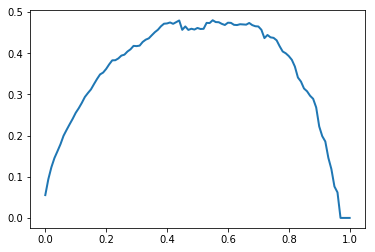

threshold 0.55
max f1_score 0.4802867383512545
eta 0.03
max_depth 3
num_round 1000


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


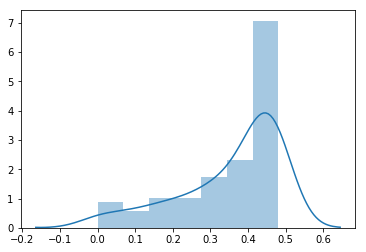

In [26]:
f1_sc = 0
max_step = 0
thr_sample = (dtest, test_y)
_score_preds = bst.predict(thr_sample[0], ntree_limit=bst.best_ntree_limit)
scores = []
for thr_step in np.linspace(0, 1, 101):
    _preds = predict(_score_preds, thr_step)
    f1_sc_step = f1_score(thr_sample[1], _preds)
    #print(thr_step, f1_sc_step)
    scores.append(f1_sc_step)
    if f1_sc_step >= f1_sc:
        f1_sc = f1_sc_step
        max_step = thr_step
plt.plot(np.linspace(0, 1, 101), scores, linewidth=2.0)
plt.show()
sns.distplot(scores)

threshold = max_step
print('threshold', threshold)
print('max f1_score', f1_sc)
print('eta', params['eta'])
print('max_depth', params['max_depth'])
print('num_round', bst.best_ntree_limit)

In [63]:
VALIDACION = rfc_key_features_data['FECHA'] > 201705
display(VALIDACION.sum())
validation_data = model_features_data[VALIDACION & MONTO_LINEA]
validation_target = target_data[VALIDACION & MONTO_LINEA]


val_y = validation_target.values
val_X = validation_data.values

dval = xgb.DMatrix(
    val_X, 
    label=val_y, 
    feature_names=validation_data.columns
)


82377

In [243]:
threshold = 0.2

In [64]:
# make predictions on datasets
train_pred = predict(bst.predict(dtrain), threshold)
test_pred = predict(bst.predict(dtest), threshold)
val_pred = predict(bst.predict(dval), threshold)

cm_train = confusion_matrix(train_y, train_pred)
cm_test = confusion_matrix(test_y, test_pred)
cm_val = confusion_matrix(val_y, val_pred)

cm_train_pct = cm_train / cm_train.astype(np.float).sum()*100
cm_test_pct = cm_test / cm_test.astype(np.float).sum()*100
cm_val_pct = cm_val / cm_val.astype(np.float).sum()*100

summary = [
    ['------', 'Train', 'Test', 'Validation'],
    ['confusion matrix', cm_train, cm_test, cm_val],
    ['confusion matrix pct', cm_train_pct, cm_test_pct, cm_val_pct],
    ['f1_score', f1_score(train_y, train_pred), f1_score(test_y, test_pred), f1_score(val_y, val_pred)],
    ['accuracy score', accuracy_score(train_y, train_pred), accuracy_score(test_y, test_pred), accuracy_score(val_y, val_pred)],
    ['recall score', recall_score(train_y, train_pred), recall_score(test_y, test_pred), recall_score(val_y, val_pred)],
    ['precision_score', precision_score(train_y, train_pred),  precision_score(test_y, test_pred), precision_score(val_y, val_pred)]
]

# print pretty table
print('thr', threshold)
print('iter', bst.best_ntree_limit)
pretty_table(summary)
print(params)


thr 0.55
iter 1000
------              	Train                      	Test                       	Validation                 
confusion matrix    	[[16672   231]             	[[4171   87]               	[[72876  1781]             
                    	 [   86   353]]            	 [  58   67]]              	 [ 1738  1476]]            
confusion matrix pct	[[96.13654711  1.33202629] 	[[95.16313028  1.98494182] 	[[93.58554532  2.28711587] 
                    	 [ 0.49590589  2.0355207 ]]	 [ 1.32329455  1.52863336]]	 [ 2.23189634  1.89544246]]
f1_score            	0.6901270772238514         	0.4802867383512545         	0.4561891515994437         
accuracy score      	0.9817206781224772         	0.9669176363221538         	0.954809877874947          
recall score        	0.8041002277904328         	0.536                      	0.45924082140634725        
precision_score     	0.6044520547945206         	0.43506493506493504        	0.45317777095486644        
{'objective': 'binary:logistic', 'et

In [158]:
# make predictions on datasets
train_pred = predict(bst.predict(dtrain), threshold)
test_pred = predict(bst.predict(dtest), threshold)

cm_train = confusion_matrix(train_y, train_pred)
cm_test = confusion_matrix(test_y, test_pred)

cm_train_pct = cm_train / cm_train.astype(np.float).sum()*100
cm_test_pct = cm_test / cm_test.astype(np.float).sum()*100

summary = [
    ['------', 'Train', 'Validation', 'Test'],
    ['confusion matrix', cm_train, cm_test],
    ['confusion matrix pct', cm_train_pct, cm_test_pct],
    ['f1_score', f1_score(train_y, train_pred), f1_score(test_y, test_pred)],
    ['accuracy score', accuracy_score(train_y, train_pred), accuracy_score(test_y, test_pred)],
    ['recall score', recall_score(train_y, train_pred), recall_score(test_y, test_pred)],
    ['precision_score', precision_score(train_y, train_pred), precision_score(test_y, test_pred)]
]

# print pretty table
print('thr', threshold)
print('iter', bst.best_ntree_limit)
pretty_table(summary)
print(params)

thr 0.62
iter 700
------              	Train                      	Validation                 
confusion matrix    	[[45574     0]             	[[11187    78]             
                    	 [    0  1850]]            	 [  112   362]]            
confusion matrix pct	[[96.09902159  0.        ] 	[[95.29772553  0.66445183] 
                    	 [ 0.          3.90097841]]	 [ 0.95408468  3.08373797]]
f1_score            	1.0                        	0.7921225382932165         
accuracy score      	1.0                        	0.9838146349774257         
recall score        	1.0                        	0.7637130801687764         
precision_score     	1.0                        	0.8227272727272728         
{'objective': 'binary:logistic', 'eta': 0.3, 'max_depth': 10, 'eval_metric': 'auc', 'scale_pos_weight': 17}
